# Структура проекта:
* Данные загружаются и предобрабатываются (в т. ч. test_df) в пункте **2.7. Пайплайн предобработки**. Пункты 1.1 - 2.6 - это EDA и объяснение действий в пайплайне.
* Разделение обучающей выборки на X и y, и обучение модели происходит в пункте **3.3. Настройка и оценка финальной модели**.
* Прогнозирование на тестовой выборке происходит в одноимённом **пункте 4**.

# Подключение библиотек и скриптов, пути к директориям и файлам

In [ ]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from scipy.stats import mode, randint

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
matplotlib.rcParams.update({'font.size': 14})

In [ ]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

MODEL_FILE_PATH = './model.pkl'

# 1. Визуализация и анализ данных

## Выводы находятся после пункта 1.3.

## Загрузка данных (для анализа)

**Задача**: Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

**Целевая переменная**:
Price

**Описание датасэта**:
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности
* **Social_1**, **Social_2**, **Social_3** - социальные показатели местности
*  **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [ ]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [ ]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0    725          58    2.0  49.882643   33.432782            6.0      6   
1  15856          74    2.0  69.263183         NaN            1.0      6   
2   5480         190    1.0  13.597819   15.948246           12.0      2   
3  15664          47    2.0  73.046609   51.940842            9.0     22   
4  14275          27    1.0  47.527111   43.387569            1.0     17   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        14.0       1972   0.310199         B         B        11      2748   
1         1.0       1977   0.075779         B         B         6      1437   
2         5.0       1909   0.000000         B         B        30      7538   
3        22.0       2007   0.101872         B         B        23      4583   
4        17.0       2017   0.072158         B         B         2       629   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
0         1           NaN            0        0       B  
1         3           NaN            0        2       B  
2        87        4702.0            5        5       B  
3         3           NaN            3        3       B  
4         1           NaN            0        0       A

In [ ]:
df.shape, test_df.shape

((10000, 20), (5000, 19))

## Уменьшение объёма памяти, который занимает датасэт

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col == 'Id':
            df[col] = df[col].astype(object)    # Это не количественная переменная

        elif col == 'DistrictId':
            df[col] = df[col].astype('category')    # Это категориальный признак

        elif col in ['Rooms', 'KitchenSquare', 'HouseFloor']:
            df[col] = df[col].astype(np.int8)    # Все значения в df целочисленные

        elif col in ['Square', 'LifeSquare', 'Price']:    # При уменьшении типа искажаются данные, поэтому их пропускаем
            continue

        elif col == 'HouseYear':    # Можно уменьшить тип
            df[col] = df[col].astype(np.int16)

        elif col == 'Healthcare_1':        # Заменим пропущенные значения на -11, чтобы изменить тип танных,
            df[col].fillna(-11, inplace=True)     # но запомним, что половина значений пропущены.
            df[col] = df[col].astype(np.int16)

        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.54 MB
Decreased by 64.4%


In [ ]:
df.dtypes

Id                 object
DistrictId       category
Rooms                int8
Square            float64
LifeSquare        float64
KitchenSquare        int8
Floor                int8
HouseFloor           int8
HouseYear           int16
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1        int16
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float64
dtype: object

## 1.1. Распределение целевой переменной

In [ ]:
df['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

In [ ]:
y = df['Price']
print(f'median - {np.quantile(y, q=0.5)}\nmean - {np.mean(y)}\nmode - {stats.mode(y)[0]}')

median - 192269.64487934904
mean - 214138.8573987384
mode - 59174.77802758123


Вместо моды показывает минимальное значение, значит все значения уникальны.

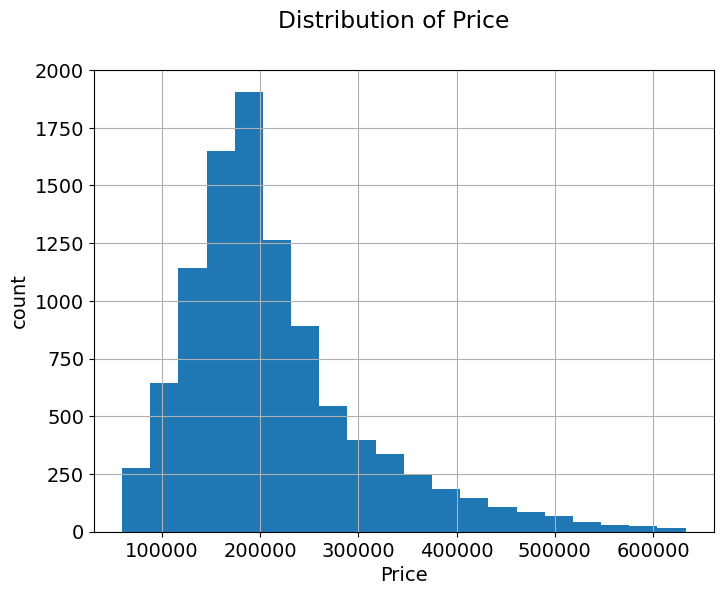

In [ ]:
plt.figure(figsize = (8, 6))

df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

Мало квартир низкой стоимости, наибольшее кол-во квартир - средней стоимости. Есть тяжёлый хвост вправо - небольшое количество достаточно дорогих объектов.

Распределение похоже на логнормальное, данные выглядят нормально, явных выбросов не видно.

In [ ]:
target_mean = round(df['Price'].mean(), 3)
target_median = df['Price'].median()
target_mode = (np.round(df['Price'] / 10) * 10).mode()[0]    # Чтобы найти моду, будем брать округлённые до десятков значения Price

In [ ]:
target_mode

181630.0

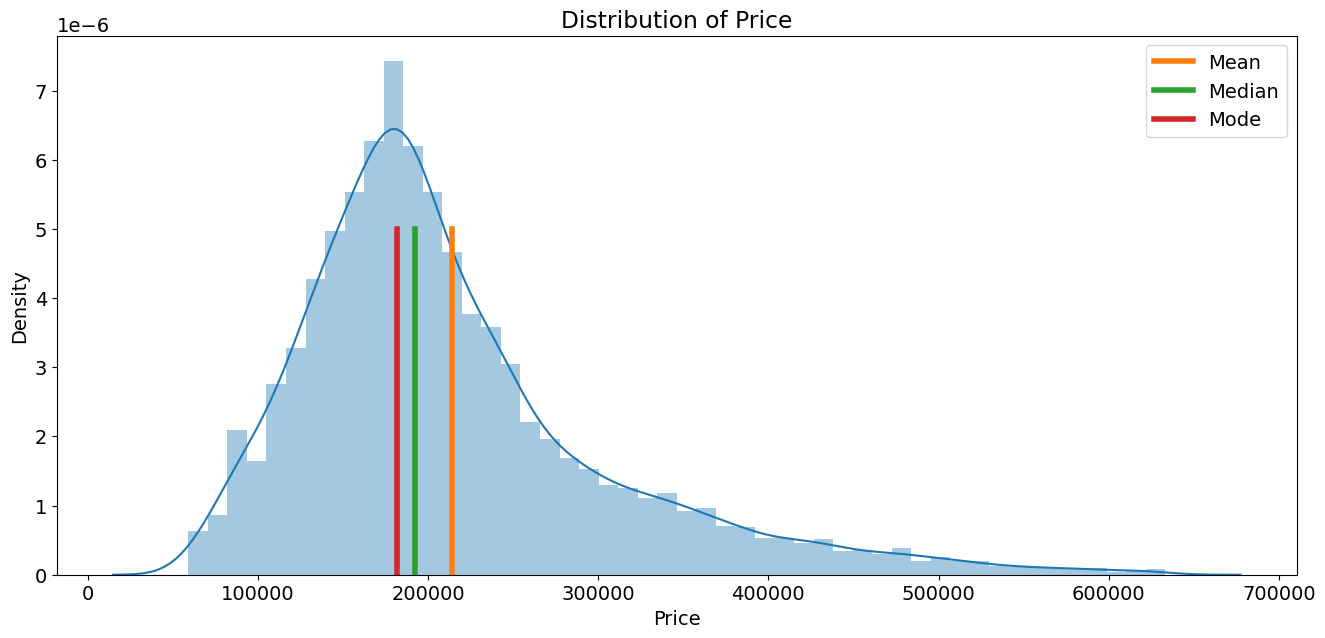

In [ ]:
plt.figure(figsize = (16, 7))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='Mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='Median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Mode', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

На этом графике такая же картина. Вначале стоимость квартир увеличивается, квартир стоимостью 175000 - 200000 - наибольшее количество. Чем выше стоимость, тем кол-во квартир уменьшается. Распределение несимметричное, с тяжёлым правым хвостом. Явных выбросов не видно.

## 1.2. Анализ признаков

### 1.2.1. Количественные признаки

#### Обзор

In [ ]:
df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       5.863700      8.526700   
std        0.839512     21.058732    86.241209       5.256699      5.241148   
min        0.000000      1.136859     0.370619     -78.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129     123.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      12.609400   1984.764700      0.118858     24.687000   5352.157400   
std        6.775974     53.112756      0.119025     17.532614   4006.799803   
min        0.000000  -2005.000000      0.000000      0.000000    168.000000   
25%        9.000000   1974.000000      0.017647      6.000000   1564.000000   
50%       13.000000   1977.000000      0.075424     25.000000   5285.000000   
75%       17.000000   2001.000000      0.195781     36.000000   7227.000000   
max      117.000000   4968.000000      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   10000.00000  10000.000000  10000.000000   10000.000000  
mean       8.039200     589.26110      1.319500      4.231300  214138.857399  
std       23.831875     935.48979      1.493601      4.806341   92872.293865  
min        0.000000     -11.00000      0.000000      0.000000   59174.778028  
25%        0.000000     -11.00000      0.000000      1.000000  153872.633942  
50%        2.000000      30.00000      1.000000      3.000000  192269.644879  
75%        5.000000     990.00000      2.000000      6.000000  249135.462171  
max      141.000000    4849.00000      6.000000     23.000000  633233.466570

Кол-во комнат 0 быть не может, Square < 11 быть не может, LifeSquare тоже, в KitchenSquare отрицательные выбросы, также 0 быть не может, HouseFloor не может быть 0, в HouseYear отрицательные значения поменять на положительные, в Healthcare половина - пропущенные данные (-11).
19 комнат - много, Square = 600 - тоже много, LifeSquare = 7480 - тоже, KitchenSquare = 123 тоже много, 117 этажей в жилых домах не бывает, 4968 год ещё не наступил.

In [ ]:
df_num_features = df.select_dtypes(exclude=['object', 'category'])
df_num_features.drop('Price', axis=1, inplace=True)

In [ ]:
df_num_features

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0         2  47.981561   29.442751              6      7           9   
1         3  65.683640   40.049543              8      7           9   
2         2  44.947953   29.197612              0      8          12   
3         2  53.352981   52.731512              9      8          17   
4         1  39.649192   23.776169              7     11          12   
...     ...        ...         ...            ...    ...         ...   
9995      2  50.401785   30.476203              5      6           5   
9996      1  41.521546   20.539216              9     13          13   
9997      1  47.939008         NaN              1     12          16   
9998      2  43.602562   33.840147              8      1           5   
9999      1  38.666645   21.157874              8      7          17   

      HouseYear  Ecology_1  Social_1  Social_2  Social_3  Healthcare_1  \
0          1969   0.089040        33      7976         5           -11   
1          1978   0.000070        46     10309         1           240   
2          1968   0.049637        34      7759         0           229   
3          1977   0.437885        23      5735         3          1084   
4          1976   0.012339        35      5776         1          2078   
...         ...        ...       ...       ...       ...           ...   
9995       1968   0.135650        46      7960         6           350   
9996       2000   0.000000        30      5562         0           -11   
9997       2015   0.072158         2       629         1           -11   
9998       1961   0.307467        30      5048         9           325   
9999       1990   0.000000        27      4798         0            30   

      Helthcare_2  Shops_1  
0               0       11  
1               1       16  
2               1        3  
3               0        5  
4               2        4  
...           ...      ...  
9995            3       11  
9996            0        5  
9997            0        0  
9998            2        5  
9999            2        8  

[10000 rows x 14 columns]

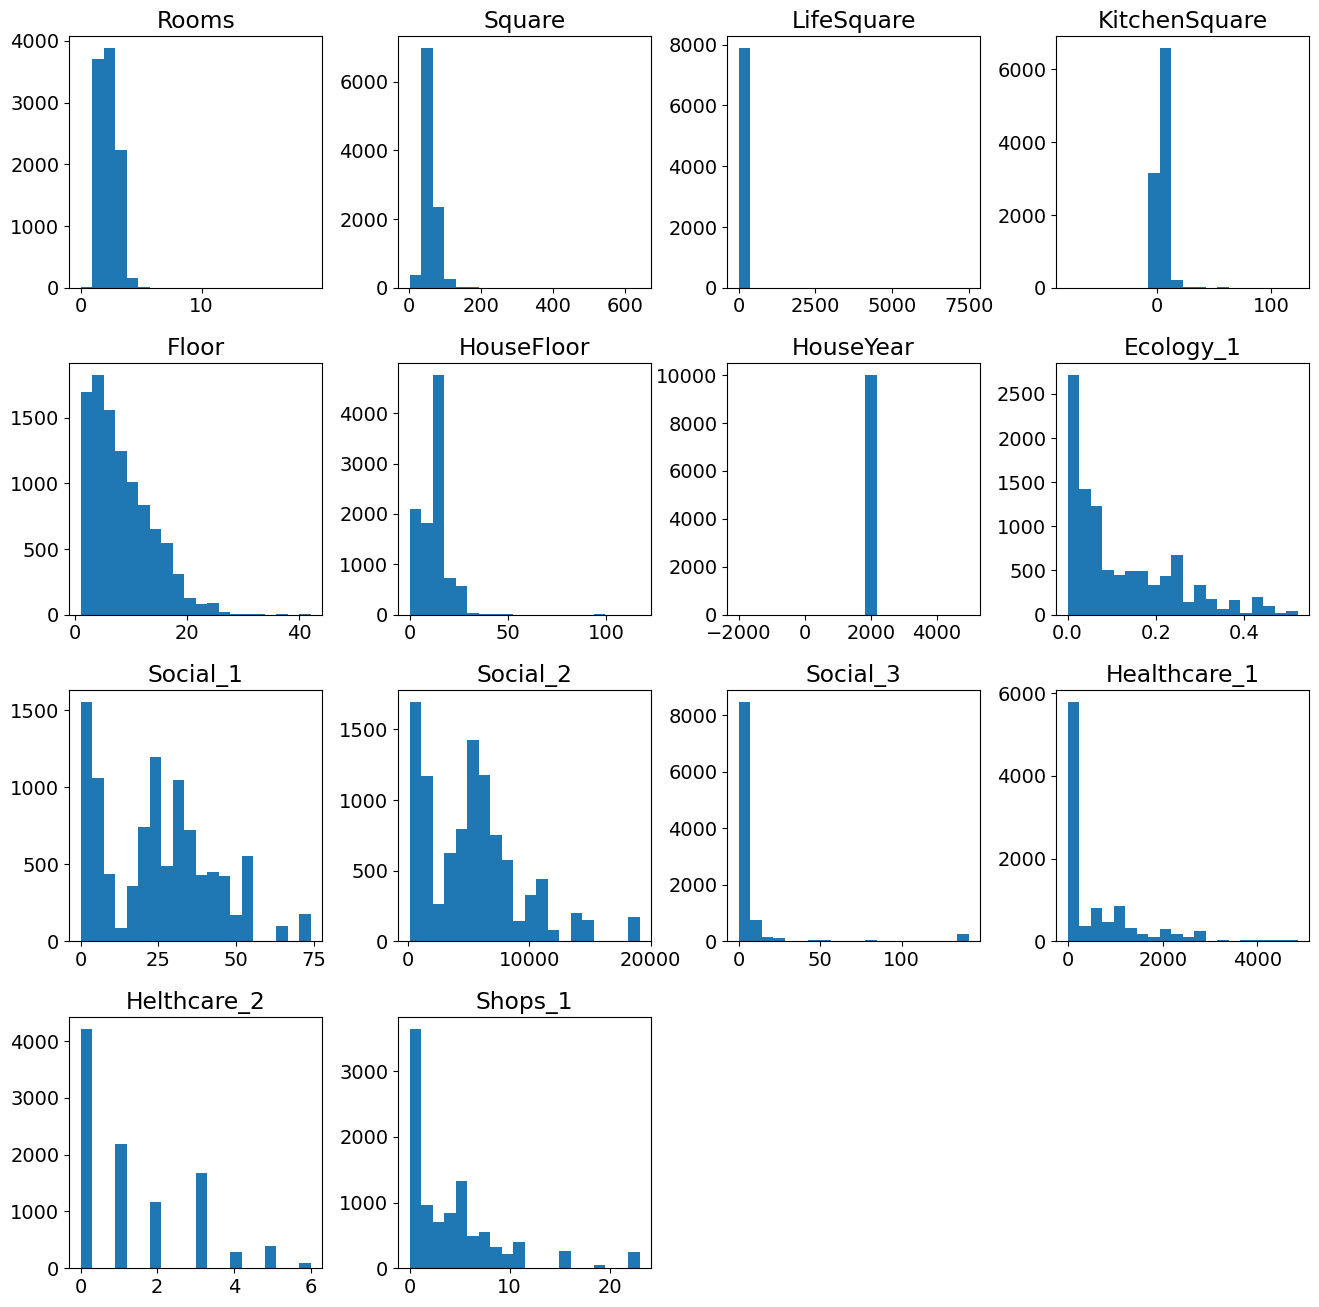

In [ ]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

По гистограммам можно сказать, что выбросы присутствуют в признаках Rooms (>10), Square (>300), LifeSquare (>1000), KitchenSquare (отрицательные
значения (пропуски) и >75), HouseFloor (>50), HouseYear (отрицательные значения и >2020).
Также можно увидеть, что много незаполненных значений в столбцах Social_3, Healthcare_1, Shops_1, Ecology_1, так как очень много значений - нулевые.

Рассмотрим странные признаки.

#### Rooms

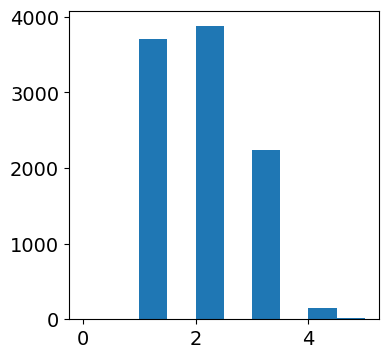

In [ ]:
df.loc[df['Rooms'] < 6, 'Rooms'].\
    hist(figsize=(4,4), bins=10, grid=False);

Хорошее распределение при кол-ве комнат до 6. Всё, что выше, - явные выбросы.

In [ ]:
df.loc[df['Rooms'] > 5, 'Rooms'] = df['Rooms'].median()

In [ ]:
df.loc[df['Rooms'] == 0, 'Rooms'] = df['Rooms'].median()

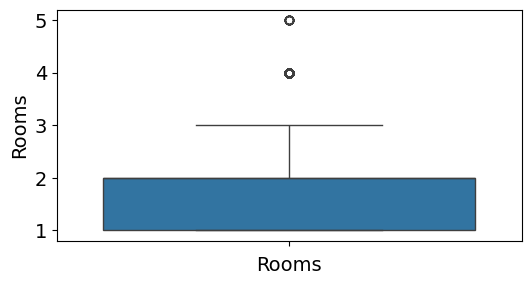

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

In [ ]:
df[df['Rooms'] >= 4]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
77     2435         85      4   65.559834   47.696255              6      6   
120    9703         15      4   98.686703   57.307058             15     10   
286     689         30      4   94.164934   60.322255             10      8   
385   14888         69      4   98.385446   76.081776              9     14   
426    3442        123      4  132.474700   68.131495             15      4   
...     ...        ...    ...         ...         ...            ...    ...   
9607   2095         55      4   94.652198   58.206761             10      3   
9699   4971        169      5  117.855969   76.561318              9     12   
9852  16641        111      4  117.201937   69.898092             14      4   
9910  16568         27      4  200.334539  201.627361             25      1   
9918  14904         34      4  104.049130   99.788387             10      8   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
77             9       1976   0.037178         B         B        52   
120           17       2008   0.158249         B         B        21   
286           16       2005   0.000078         B         B        22   
385           22       1979   0.000991         B         B        33   
426           15       2008   0.000000         B         B         6   
...          ...        ...        ...       ...       ...       ...   
9607          12       2000   0.041365         B         B        31   
9699          14       2001   0.178917         B         B        18   
9852           2       2017   0.093443         B         B        23   
9910           2       2013   0.041116         B         B        53   
9918          25       2018   0.069753         B         B        53   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
77       11217         1          2300            1        7       B   
120       5731         0            30            1        0       B   
286       6398       141          1046            3       23       B   
385       6783         3            30            1        9       B   
426       2733         0           920            0        4       B   
...        ...       ...           ...          ...      ...     ...   
9607      5569         0            30            1        4       B   
9699      3594         4           192            1        5       B   
9852      4635         5          3300            2        4       B   
9910     14892         4            30            1        4       B   
9918     13670         4            30            1       11       B   

              Price  
77    266989.016142  
120   373510.057128  
286   517817.162981  
385   547029.902689  
426   573451.655822  
...             ...  
9607  351076.213145  
9699  608674.130507  
9852  197593.112769  
9910  528560.506016  
9918  411971.106869  

[168 rows x 20 columns]

4 и 5 комнат - выбросами не являются. У них соответствующая площадь и цена.

#### Square

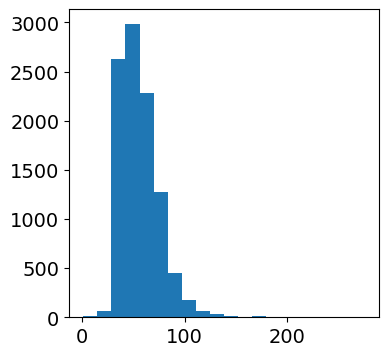

In [ ]:
df.loc[df['Square'] < 300, 'Square'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [ ]:
df[df['Square'] > 200]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1981   7917         27      0  212.932361  211.231125              0      2   
1982   5548         86      5  275.645284  233.949309             26     12   
4262     28          9      2  604.705972         NaN              1     17   
4690   2307        102      1  409.425181  410.639749             10      4   
6977  11602         30      2  641.065193  638.163193             10     20   
9910  16568         27      4  200.334539  201.627361             25      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1981           3       2008   0.211401         B         B         9   
1982          37       2011   0.161976         B         A        31   
4262          18       1977   0.161532         B         B        25   
4690           4       2016   0.238617         B         B        26   
6977          19       2019   0.000078         B         B        22   
9910           2       2013   0.041116         B         B        53   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1981      1892         0           -11            0        1       B   
1982      7010         5          4508            3        7       B   
4262      5648         1            30            2        4       B   
4690      3889         6           705            3        6       B   
6977      6398       141          1046            3       23       B   
9910     14892         4           -11            1        4       B   

              Price  
1981  302211.260887  
1982  455264.882666  
4262  187717.242538  
4690   90470.430830  
6977  133529.681562  
9910  528560.506016

Всё, что выше 300 - выбросы. Но можно заметить, что Square и LifeSquare этих выбросов можно поделить на 10, и тогда они станут валидными данными.

In [ ]:
df.loc[df['Square'] > 300, 'LifeSquare'] = df['LifeSquare'] / 10
df.loc[df['Square'] > 300, 'Square'] = df['Square'] / 10

In [ ]:
df.loc[df['Square'] == 0, 'Square'] = df['Square'].median()

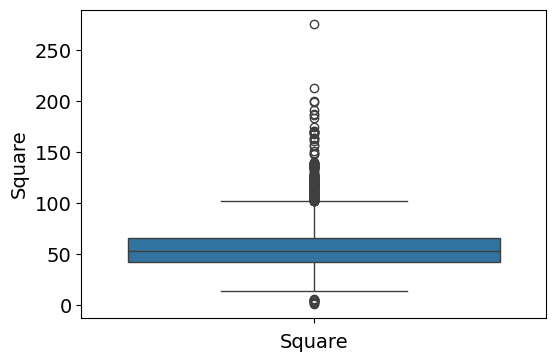

In [ ]:
plt.figure(figsize=(6, 4))

sns.boxplot(df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [ ]:
df[df['Square'] <= 11]

Id DistrictId  Rooms    Square  LifeSquare  KitchenSquare  Floor  \
212    1748         88      2  5.497061   67.628717              1     24   
1316  11526         27      1  4.633498    1.969969              1     18   
1608  10202          6      1  2.596351    4.604943              1      3   
3280  10527         27      1  4.380726   40.805837              1     10   
3413   9487          5      1  5.129222    5.549458              1      1   
4853   3224         27      2  2.377248    0.873147              0      1   
4900   4504         27      3  4.390331    5.610772              1      8   
6392  14786          1      1  1.136859    4.525736              6      3   
8030  13265          1      3  4.823679   79.767964              0      6   
8283  15744         34      1  1.988943    2.642219              6     21   
9294   6782         45      1  2.954309    5.257278              1      3   
9613   7657         38      1  4.502784    4.618547              1     28   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
212           22       1977   0.127376         B         B        43   
1316           1       1977   0.011654         B         B         4   
1608          25       2014   0.243205         B         B         5   
3280          17       2013   0.211401         B         B         9   
3413           1       1977   0.150818         B         B        16   
4853          13       1977   0.017647         B         B         2   
4900          19       2016   0.211401         B         B         9   
6392           1       1977   0.007122         B         B         1   
8030          17       1977   0.007122         B         B         1   
8283           4       1977   0.069753         B         B        53   
9294           1       1977   0.195781         B         B        23   
9613           1       1977   0.060753         B         B        15   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
212       8429         3            30            3        9       B   
1316       915         0            30            0        0       B   
1608      1564         0           540            0        0       B   
3280      1892         0            30            0        1       B   
3413      3433         4          2643            4        5       B   
4853       469         0            30            0        0       B   
4900      1892         0            30            0        1       B   
6392       264         0            30            0        1       B   
8030       264         0            30            0        1       B   
8283     13670         4            30            1       11       B   
9294      5212         6            30            3        2       B   
9613      2787         2           520            0        7       B   

              Price  
212   412511.088764  
1316  107604.269441  
1608  137597.601458  
3280   97560.720383  
3413  369472.403061  
4853  126596.941798  
4900  161379.067034  
6392  181434.825589  
8030  237716.681261  
8283  458378.777006  
9294  438005.182323  
9613  483283.488083

Площадь менее 11 кв. м. - выбросы, потому что не бывает квартир такой маленькой площади.

In [ ]:
df[df['Square'] > 200]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1981   7917         27      2  212.932361  211.231125              0      2   
1982   5548         86      5  275.645284  233.949309             26     12   
9910  16568         27      4  200.334539  201.627361             25      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1981           3       2008   0.211401         B         B         9   
1982          37       2011   0.161976         B         A        31   
9910           2       2013   0.041116         B         B        53   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1981      1892         0            30            0        1       B   
1982      7010         5          4508            3        7       B   
9910     14892         4            30            1        4       B   

              Price  
1981  302211.260887  
1982  455264.882666  
9910  528560.506016

Это не выбросы, потому что цена у них соответствующая

In [ ]:
df.loc[df['Square'] <= 11, 'Square'] = df['Square'].median()

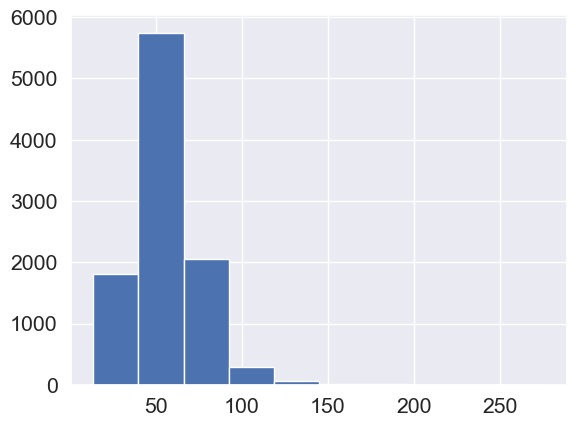

In [ ]:
df['Square'].hist();

#### LifeSquare

In [ ]:
df[df['LifeSquare'] > 200]

Id DistrictId  Rooms      Square   LifeSquare  KitchenSquare  Floor  \
590   14990         23      2   48.449873   263.542020              5      6   
1981   7917         27      0  212.932361   211.231125              0      2   
1982   5548         86      5  275.645284   233.949309             26     12   
4328  16550         27      3   81.694417  7480.592129              1      9   
8437  15886         85      3   78.059331   461.463614             10     12   
9910  16568         27      4  200.334539   201.627361             25      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
590            5       1972   0.075779         B         B         6   
1981           3       2008   0.211401         B         B         9   
1982          37       2011   0.161976         B         A        31   
4328          17       2016   0.017647         B         B         2   
8437          16       1998   0.037178         B         B        52   
9910           2       2013   0.041116         B         B        53   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
590       1437         3           -11            0        2       B   
1981      1892         0           -11            0        1       B   
1982      7010         5          4508            3        7       B   
4328       469         0           -11            0        0       B   
8437     11217         1          2300            1        7       B   
9910     14892         4           -11            1        4       B   

              Price  
590   141780.231857  
1981  302211.260887  
1982  455264.882666  
4328  217357.492366  
8437  394253.299978  
9910  528560.506016

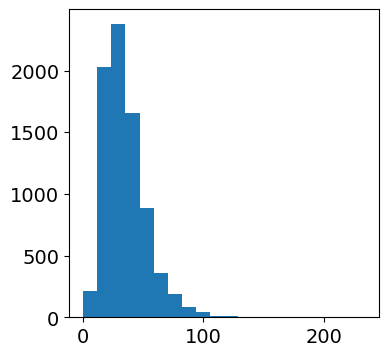

In [ ]:
df.loc[df['LifeSquare'] < 250, 'LifeSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

Всё, что выше 250, - выбросы.

In [ ]:
df.loc[df['LifeSquare'] > 250, 'LifeSquare'] = df['LifeSquare'].median()

In [ ]:
df.loc[df['LifeSquare'] == 0, 'LifeSquare'] = df['LifeSquare'].median()

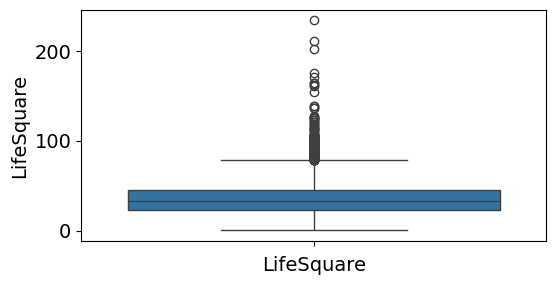

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

In [ ]:
df[df['LifeSquare'] > 150]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1641  11055        151      1  174.649522  174.837082             15     10   
1981   7917         27      2  212.932361  211.231125              0      2   
1982   5548         86      5  275.645284  233.949309             26     12   
2603   5621         23      3  163.495333  161.504222             12      5   
3651   5300         30      3  169.509941  170.713651              1      2   
4047  15362         23      1  163.286965  161.155275              1      4   
5444  14181         62      3  156.636577  153.685835              1      1   
6332   8961         27      1   33.398983  164.153360              6      3   
8913   2603         30      3  162.587886  164.526757              0      2   
9910  16568         27      4  200.334539  201.627361             25      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1641          12       1958   0.236108         B         B        16   
1981           3       2008   0.211401         B         B         9   
1982          37       2011   0.161976         B         A        31   
2603           3       1977   0.014073         B         B         2   
3651           2       2018   0.000078         B         B        22   
4047           3       1977   0.014073         B         B         2   
5444           3       2005   0.072158         B         B         2   
6332           5       1965   0.211401         B         B         9   
8913           3       1977   0.000078         B         B        22   
9910           2       2013   0.041116         B         B        53   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1641      3893        27            30            3       10       B   
1981      1892         0            30            0        1       B   
1982      7010         5          4508            3        7       B   
2603       475         0            30            0        0       B   
3651      6398       141          1046            3       23       B   
4047       475         0            30            0        0       B   
5444       629         1            30            0        0       A   
6332      1892         0            30            0        1       B   
8913      6398       141          1046            3       23       B   
9910     14892         4            30            1        4       B   

              Price  
1641  232766.187698  
1981  302211.260887  
1982  455264.882666  
2603  207007.956663  
3651  200800.673767  
4047  228572.520347  
5444  502523.573863  
6332  104891.073757  
8913  207407.352593  
9910  528560.506016

Это не выбросы, потому что значения похожи на Square. Мы можем заменить те значения, где большая разница со Square.

In [ ]:
df.loc[df['LifeSquare']/df['Square'] > 4, 'LifeSquare'] = df['LifeSquare'].median()

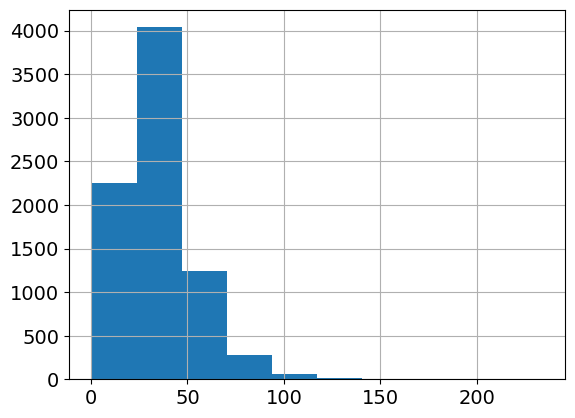

In [ ]:
df['LifeSquare'].hist();

#### KitchenSquare

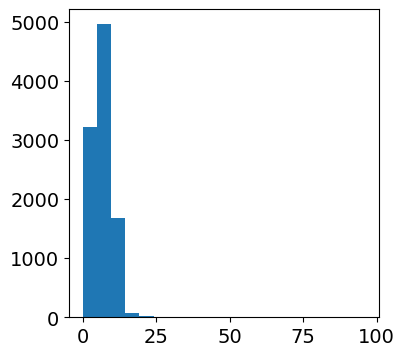

In [ ]:
df.loc[(df['KitchenSquare'] >= 0) & (df['KitchenSquare'] < 100), 'KitchenSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [ ]:
df[df['KitchenSquare']/df['Square'] > 0.5]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
227   16395          2      3   79.722243   44.731219             72     12   
551    1315          6      1   48.128114   45.023531             48     21   
1077   9690         27      1   40.081042   37.834964             37     18   
1369   2371         27      2   68.841073   64.234956             66      4   
1455  12507         54      2   79.810535   79.578961             78     10   
1860   4265        161      2   53.216778   32.644859             53      7   
2916  12390         72      3   97.490674   99.323558             96     22   
2969   7441         62      3  114.734473  112.589083            112      3   
3379  16781         27      1   36.138409   36.710539             36     19   
4079   6508         23      2   67.146049   33.959154             63      5   
4110    299         27      2   66.787523   64.616662             60     14   
4142  15466         88      1   42.357487   44.779714             41     10   
4588    448         48      1   41.186904    1.626502             41      2   
4651  12552         58      3  116.405693  113.109653            112      3   
4739  12676         81      3   13.784865   15.988889              7      4   
5149  13703         42      1   38.071692   19.723548             73      9   
5162  11739         27      2   61.070298   59.845092             58      8   
5480  15781         10      1   35.813564   19.953992             35      6   
5816   2271         27      1   43.292516   42.835643             40     12   
5849  11624         46      1   42.983283   24.224435             37     15   
5888  16593         52      2   64.859242         NaN             62     15   
5904    673         27      1   54.418214   51.498581             51     10   
6036  12666         34      2   60.603363    2.400832             58     14   
6240   4966         96      3   78.445675   47.146757             75      9   
6392  14786          1      1    1.136859    4.525736              1      3   
7088   6569         27      1   38.220258   18.716856             84      4   
7480  10546         62      1   46.013187   43.417043             43      4   
8232   7162         34      2   56.738764   57.510395             54     26   
8283  15744         34      1    1.988943    2.642219              1     21   
9111   6708         48      1   42.069359   22.487739             39      1   
9889  12918         23      2   51.440463   53.134243             51      3   
9895   2737         27      3  123.430072  125.806981            123      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
227           16       1987   0.130618         B         B        39   
551            1       2013   0.243205         B         B         5   
1077          19       2019   0.211401         B         B         9   
1369           2       2014   0.017647         B         B         2   
1455          15       2014   0.006076         B         B        30   
1860          17       1994   0.000699         B         B        14   
2916          25       2019   0.210473         B         B        11   
2969           3       2015   0.072158         B         B         2   
3379          19       2017   0.072158         B         B         2   
4079          17       2019   0.034656         B         B         0   
4110          20       2015   0.017647         B         B         2   
4142          19       2016   0.127376         B         B        43   
4588           1       1977   0.041125         B         B        46   
4651           3       2016   0.437885         B         B        23   
4739           5       1960   0.319809         B         B        25   
5149          10       2006   0.158249         B         B        21   
5162          17       2016   0.072158         B         B         2   
5480          14       1971   0.282798         B         B        33   
5816          11       2015   0.2

Отрицательные значения и значения, где доля кухни от общей площади > 0.5 - выбросы.

In [ ]:
df.loc[df['KitchenSquare'] < 0, 'KitchenSquare'] = df['KitchenSquare'].median()

In [ ]:
df.loc[df['KitchenSquare']/df['Square'] > 0.5, 'KitchenSquare'] = df['KitchenSquare'].median()

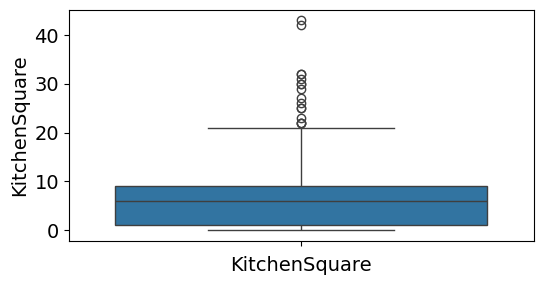

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['KitchenSquare'], whis=1.5)

plt.xlabel('KitchenSquare')
plt.show()

In [ ]:
df[df['KitchenSquare'] > 20]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
622   12924         30      3   92.473796   53.649526             22      3   
1804  11459         79      1   98.727990   49.781722             22     18   
1867   3267         58      3  138.980817  138.004600             43      2   
1982   5548         86      5  275.645284  233.949309             26     12   
2656  14556        183      4  151.150660   98.187482             23      6   
3368   6674         54      1  168.086347  125.486563             30     18   
3431   7111         27      2  139.070296   89.787666             42      5   
5087  15947        129      4  185.906396   84.830074             31      5   
5494    300         31      2  106.427686   34.230415             32      4   
5653   8500         31      1   80.606246   25.299592             29      6   
6988   8685         62      5  124.933289   81.122369             30      5   
7201   3233        129      4  186.692602   87.487080             32      3   
7249   3431         62      2   60.715426   40.720961             25      5   
8182  16511         52      3  135.731888   71.583248             21     26   
8390  13559         79      1   96.838013   49.140960             22     19   
8921  12074         94      3  108.957285   51.063721             27      2   
9910  16568         27      4  200.334539  201.627361             25      1   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
622            2       2018   0.000078         B         B        22   
1804          24       2019   0.050756         B         B        24   
1867           2       1977   0.437885         B         B        23   
1982          37       2011   0.161976         B         A        31   
2656           7       1912   0.037316         B         B        32   
3368          28       2011   0.006076         B         B        30   
3431           3       2016   0.014073         B         B         2   
5087           3       2015   0.020741         B         B        24   
5494          40       2013   0.151346         B         A        32   
5653          40       2014   0.151346         B         A        32   
6988           3       2017   0.072158         B         B         2   
7201           3       2011   0.020741         B         B        24   
7249          12       2012   0.386772         B         B         5   
8182          25       2008   0.371149         B         B        34   
8390          24       2016   0.050756         B         B        24   
8921          22       2008   0.282798         B         B        33   
9910           2       2013   0.041116         B         B        53   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
622       6398       141          1046            3       23       B   
1804      5469         1           145            0        1       B   
1867      5735         3          1084            0        5       B   
1982      7010         5          4508            3        7       B   
2656      6748        93           562            4       10       B   
3368      5285         0           645            6        6       B   
3431       475         0            30            0        0       B   
5087      5613         5          1340            2        5       B   
5494      5889        10           830            4        1       B   
5653      5889        10           830            4        1       B   
6988       629         1            30            0        0       A   
7201      5613         5          1340            2        5       B   
7249      1135         0            30            0        0       A   
8182      7065         1           750            2        5       B   
8390      5469         1           145            0        1       B   
8921      8667         2            30            0        6       B   
9910     14892         4            30            1        4     

Похоже не на выбросы, а на большие кухни больших квартир

#### Floor

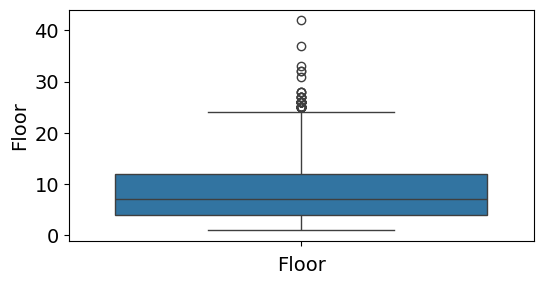

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Floor'], whis=1.5)

plt.xlabel('Floor')
plt.show()

In [ ]:
df[df['Floor'] > 25]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
95     4280         34      2   61.334968    4.091945              1     26   
339   11563          8      1   50.390862   41.642898              0     32   
343     716        113      3  125.287183  127.477137             19     26   
561   11692        113      2   70.566571   70.694221             12     28   
1406   1636         30      2   60.185450         NaN              1     26   
1666  13202         34      2   62.874315         NaN              1     26   
1956  15157         54      1  106.239622   83.296167             17     26   
2002  15303         48      3   83.866174         NaN              1     26   
2219   5685         45      3   77.951569   76.450002             10     26   
2308   1471         23      2   62.348477         NaN              1     27   
2517   8241          8      4  101.528444   95.003030             10     26   
2597   4320         29      1   47.235843   21.629796             12     28   
2781   1674         76      2   74.344672   41.044132              5     42   
2848   7838         48      3   86.059789    3.434851              1     27   
3323  15704         45      1   42.768644   42.674844              1     27   
3330   3298         31      1   57.551691   21.551876             10     32   
3785   8582         29      3   80.838369   45.049299              8     26   
4119    370          6      3   82.030903   78.922956              0     27   
4323   6589         30      1   62.110823   52.812128              4     31   
4645   7862         27      3   48.652482         NaN              0     26   
5452  11625         84      1  102.640234   78.746443             19     26   
6094   9021         23      1  103.744170  105.338395              1     26   
6170  12744          6      2   62.333879         NaN              1     26   
6755   8296        146      1   86.386754   71.904999              0     37   
7697   5976          6      3  103.297933         NaN              0     26   
8182  16511         52      3  135.731888   71.583248             21     26   
8232   7162         34      2   56.738764   57.510395              6     26   
8357   8016         31      1   59.519896   24.050533             10     33   
8409   6514         94      1   45.902534   17.229169             10     27   
9434  10193          1      1   47.293596         NaN              1     26   
9613   7657         38      1   52.509275    4.618547              1     28   
9989   4145         96      3   90.055233   47.860231             11     26   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
95             1       2014   0.069753         B         B        53   
339           32       2008   0.092291         B         B        21   
343           24       2017   0.050756         B         B        24   
561           30       2014   0.050756         B         B        24   
1406          24       1977   0.000078         B         B        22   
1666           1       1977   0.069753         B         B        53   
1956          37       2009   0.006076         B         B        30   
2002           1       2014   0.041125         B         B        46   
2219          24       2017   0.195781         B         B        23   
2308          25       1977   0.075779         B         B         6   
2517          24       2010   0.092291         B         B        21   
2597          30       2015   0.069660         B         B        31   
2781          48       2016   0.000000         B         B         7   
2848           1       2015   0.041125         B         B        46   
3323          25       2016   0.195781         B         B        23   
3330          40       1977   0.151346         B         A        32   
3785          25       2010   0.069660         B         B        31   
4119          25       1977   0.243205         B         B         5   
4323          44       2009   0.0

Это не выбросы, бывают и такие высокие этажи, учитывая то, что дома не старше 1977 года.

#### HouseFloor

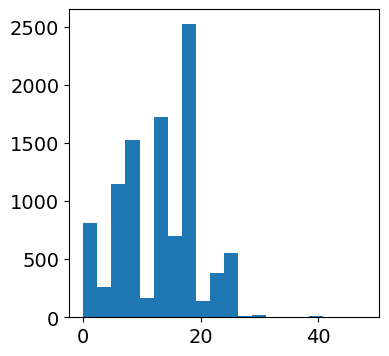

In [ ]:
df.loc[(df['HouseFloor'] <= 95), 'HouseFloor'].\
    hist(figsize=(4,4), bins=20, grid=False);

Значения > 95 - выбросы

In [ ]:
df.loc[df['HouseFloor'] > 95, 'HouseFloor'] = df['HouseFloor'].median()

In [ ]:
df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

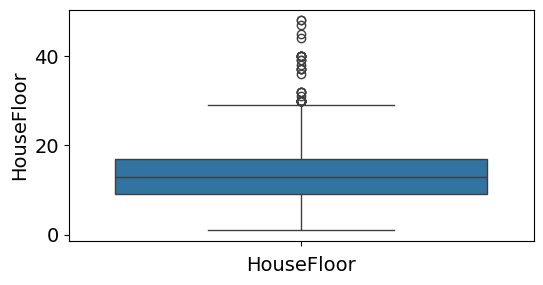

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['HouseFloor'], whis=1.5)

plt.xlabel('HouseFloor')
plt.show()

In [ ]:
df[df['HouseFloor'] > 25]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
132    3428        108      3  110.203969   59.270702             12     19   
339   11563          8      1   50.390862   41.642898              0     32   
359   15722         31      2   82.435495   48.655394             16     23   
382   15586         24      3   78.695827   49.947971              9      9   
448    8119         27      3   56.579350         NaN             12     24   
540    5279         93      2   60.804544   30.923827             11      5   
558    9193         26      2   76.915978   43.799723             12      3   
561   11692        113      2   70.566571   70.694221             12     28   
1288  14008         26      1   49.992258   20.277695             11      6   
1335  10611         29      4  126.114546   81.008727             11      7   
1357  14472         66      3  104.898559   55.606246             13      4   
1956  15157         54      1  106.239622   83.296167             17     26   
1982   5548         86      5  275.645284  233.949309             26     12   
1983   2788         26      1   56.636234   22.923720             11      5   
2597   4320         29      1   47.235843   21.629796             12     28   
2781   1674         76      2   74.344672   41.044132              5     42   
2945  13898         26      2   77.621144   41.838484             14     11   
3228  15192         26      3  117.714551   57.440648             15     17   
3330   3298         31      1   57.551691   21.551876             10     32   
3368   6674         54      1  168.086347  125.486563             30     18   
3634   8504         29      3   95.989659   56.583835             12     19   
3662   1102         54      3  101.279843   52.188698             20     20   
3858   5658         17      3   75.276260   45.187294              0     19   
3863   1749         26      2   79.892246   44.445955             13      6   
3974   6502         20      1  126.389517  103.637322             14     22   
4098    782         26      2   83.795579   40.548087             13      5   
4181  12837         46      1   40.097663    2.752436              1      3   
4323   6589         30      1   62.110823   52.812128              4     31   
4414   8955         54      2   77.456242   52.737233             18     12   
4481   7789        146      1   60.890931   45.768512             11     13   
4525  14773         30      1  105.619549   87.387096              5     14   
4778  16263        118      1   56.403257   38.358511             14      7   
5047   2377         34      2   57.350700         NaN             10     25   
5141    656         26      1   56.472075   27.739383             13     10   
5270   6327        146      3   75.037085   45.811037              9     11   
5452  11625         84      1  102.640234   78.746443             19     26   
5494    300         31      2  106.427686   34.230415             32      4   
5653   8500         31      1   80.606246   25.299592             29      6   
5733   4697         29      1   49.116483   22.044498             10      9   
5890  12251         26      3  116.052846   56.051303             14      7   
6459   3302         30      2  104.511894   86.460171              6     25   
6755   8296        146      1   86.386754   71.904999              0     37   
6930  13906         26      1   57.088640   23.298211             10      4   
7273  15360         27      1   31.276397   14.057882              6     21   
7299  16294         26      2   77.222534   42.824248             14     14   
7728   7453         24      3  126.621358   62.455481             12     22   
8060   7763         29      2   74.478408   39.382330             11      3   
8112   3665         26      2   83.044357   41.793793             13      7   
8179  15307        118      2   57.356214   36.953900              5     16   
8340  15270         31      2   81.042938   46.633001      

То же самое: это не выбросы, это высокоэтажные дома не старше 1977 года.

#### HouseYear

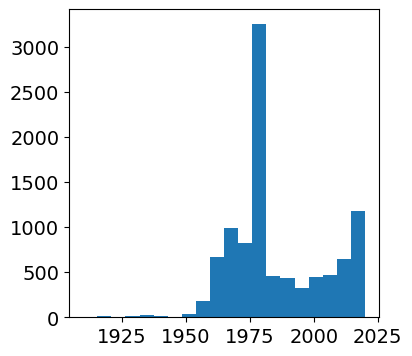

In [ ]:
df.loc[(df['HouseYear'] > 1800) & (df['HouseYear'] < 2024), 'HouseYear'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [ ]:
df[(df['HouseYear'] < 1910) | (df['HouseYear'] > 2020)]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1497  10814        109      1  37.265070   20.239714              9      9   
4189  11607        147      2  44.791836   28.360393              5      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1497          12      -2005   0.136330         B         B        30   
4189           9       4968   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1497      6141        10           262            3        6       B   
4189      4756        16          2857            5        8       B   

              Price  
1497  254084.534396  
4189  243028.603096

<1910, >2020 - выбросы

In [ ]:
df.loc[df['HouseYear'] < 0, 'HouseYear'] = abs(df['HouseYear'])
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df['HouseYear'].median()

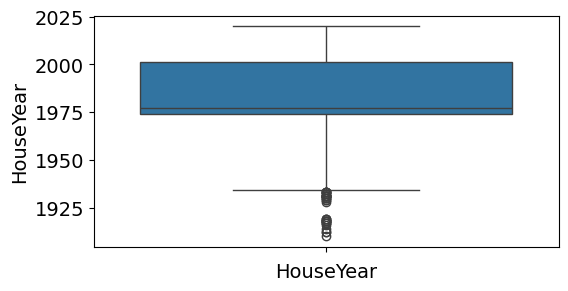

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['HouseYear'], whis=1.5)

plt.xlabel('HouseYear')
plt.show()

In [ ]:
df[df['HouseYear'] < 1937]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
837   14261        174      3   65.812757   48.988726              6      5   
910    6751        172      2   56.172364   28.384213              7      8   
1029  13234        157      1   28.145334   17.650399              4      4   
1033   8286        172      4  101.496365   72.482796              9     11   
1089  10456         82      3   77.811823   48.790816              5      7   
1380  15193        195      3   75.564709   44.872616              9      5   
1386  12229        180      2   76.083312   48.026246             14      6   
2130  12370         95      2   47.616209   30.512932              6      1   
2554  10919        190      2   47.489415   35.564479              4      5   
2588   7018        120      3   87.848494   56.589076             11      2   
2608  12329         51      2   52.665130   30.099008              8      4   
2615  14401         46      2   56.591586   37.604037              9      4   
2656  14556        183      4  151.150660   98.187482             23      6   
2902  14543        120      4   96.730985   53.589223             17      4   
2933    380         95      2   68.178921   34.851016             11      6   
3443  11120        207      3   76.780960   55.770043              7      2   
3848  10645        142      3   89.718197   58.747599             12      6   
3883   1313         95      2   44.495644   30.377814              5      5   
3933   4212        135      3   63.922700   41.738588              7      3   
4143  15720        101      3   73.397964   42.475042             15      5   
4904    462         43      1   44.082183   27.717690              7      4   
4949   8921        159      3   69.589661   48.856723              5      1   
5016  15375        182      2   67.838861   65.200025              9      7   
5053  10439        104      1   35.507738   20.312725              4      6   
5111   2085        161      1   63.293079   29.389815             18      3   
5240  12304        104      3   61.690768   43.802429              4      2   
5667   4352        104      2   28.517666   15.565872              3      7   
5900   3239        120      1   36.570979   22.051734              7      6   
6208  14966          7      2   49.652807   29.200777              8      4   
6277   2726        155      2   61.714109   32.486988              9      7   
6630  15902         97      1   40.398617   19.501462              9      6   
6846   5313        175      4   78.204702   63.867593              4      6   
7163   6700        168      2   59.385076   29.235410              9      2   
7562   5078         82      3   70.023486   51.236075              7      6   
7611   7920        183      3  102.964468   48.322107             14      4   
8055  15590        157      3   65.203978   42.319012              9      5   
8144  13872        189      2   54.751367   31.515082             10      2   
8163  16018        190      3   76.297535   53.913148              6     10   
8207  14248        105      3   71.093710   46.573040              7      6   
8381   3128        157      3   84.630693   55.849041             11      4   
8493   2574        159      2   43.439367   29.328888              6      5   
8505  12381        182      3   65.475260   44.184674              7      3   
8595  12941        188      4   86.482556   70.112069              5      6   
8685   1268        159      4   88.947262   64.483490              7      6   
8951   9642         73      3   68.416428   47.767216              7      6   
9317  13288        161      1   50.808925   15.920343             20      8   
9370   8396        202      2   42.353485   30.661180              6      4   
9506  10240        129      2   47.328949   27.931664              8      2   
9566  16522         33      3   64.460827   42.088742              6      1   
9825  15391        184      3   64.048840   42.844486      

Это не выбросы, бывают такие старые дома.

#### Ecology_1

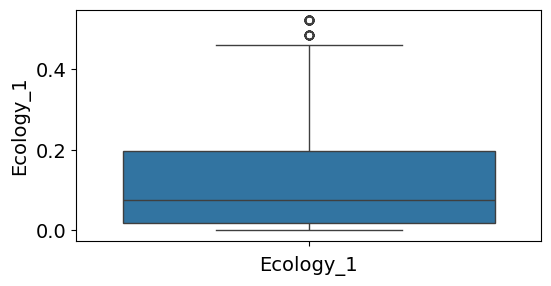

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Ecology_1'], whis=1.5)

plt.xlabel('Ecology_1')
plt.show()

In [ ]:
df[df['Ecology_1'] > 0.45]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
6     14549        154      2  62.254114   37.160377              7      3   
133   15386        127      2  45.923673   26.177753              5      3   
149   10666         94      1  37.985752   20.142099              9      8   
189    3035         94      2  47.802228   32.542126              6      5   
191   14077         92      2  42.540094   27.662918              6     12   
...     ...        ...    ...        ...         ...            ...    ...   
9635   2551        154      2  46.974426   32.035539              5      5   
9655   8014          8      1  40.956814   20.134366              7      9   
9724   2806          8      2  48.074746   31.414141              5      9   
9781   7250         47      2  45.312434   32.157888              5      6   
9853  12913          8      2  48.406418   30.717760              5     13   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
6              5       1960   0.460556         B         B        20   
133            5       1967   0.486246         B         B        13   
149           16       1974   0.521867         B         B        25   
189           12       1975   0.521867         B         B        25   
191           12       1971   0.460556         B         B        20   
...          ...        ...        ...       ...       ...       ...   
9635           5       1962   0.460556         B         B        20   
9655          14       2007   0.458174         B         A        26   
9724          12       1969   0.458174         B         A        26   
9781           5       1967   0.458174         B         A        26   
9853          12       1968   0.458174         B         A        26   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
6         4386        14            30            1        5       B   
133       2514        19            30            0        6       B   
149       6149         0            30            0        0       B   
189       6149         0            30            0        0       B   
191       4386        14            30            1        5       B   
...        ...       ...           ...          ...      ...     ...   
9635      4386        14            30            1        5       B   
9655      4439         1          1130            1        5       B   
9724      4439         1          1130            1        5       B   
9781      4439         1          1130            1        5       B   
9853      4439         1          1130            1        5       B   

              Price  
6     296021.204377  
133   176480.465173  
149   137656.122924  
189   162335.014034  
191   208662.676123  
...             ...  
9635  208710.914456  
9655  203513.510804  
9724  200777.319094  
9781  178099.073823  
9853  212792.292586  

[159 rows x 20 columns]

Это не выбросы, просто высокие оценки

#### Social_1

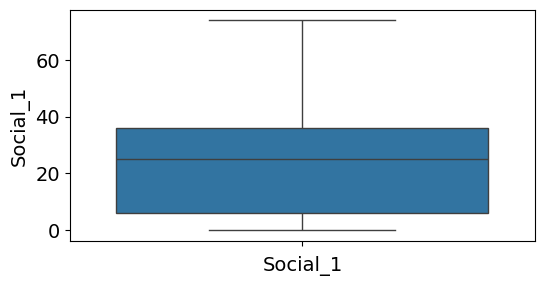

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_1'], whis=1.5)

plt.xlabel('Social_1')
plt.show()

Отличный признак

#### Social_2

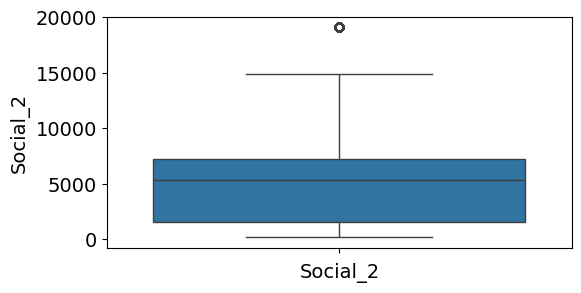

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_2'], whis=1.5)

plt.xlabel('Social_2')
plt.show()

In [ ]:
df[df['Social_2'] > 15000]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
12     6452         13      2  54.522805   31.759753              1      8   
198   10736         13      3  80.030330   47.801599             10     16   
278    8179         13      2  55.232957   32.530879              8     11   
325   10550         12      3  81.734269   48.328522             10      8   
377    5927         57      2  59.056975   36.223072             10     22   
...     ...        ...    ...        ...         ...            ...    ...   
9862   5785         13      1  42.053535   24.087096             10     11   
9872  14136         12      1  43.711302   20.130061              8     18   
9935   6608         13      2  59.384809   36.738844             10      2   
9956  10715         13      1  38.475794   20.461320             10     17   
9993     48         13      3  80.631333   48.899083             10     11   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
12            12       1999   0.090799         B         B        74   
198           17       1992   0.090799         B         B        74   
278           17       1998   0.090799         B         B        74   
325           14       1995   0.090799         B         B        74   
377           22       2002   0.090799         B         B        74   
...          ...        ...        ...       ...       ...       ...   
9862          22       2002   0.090799         B         B        74   
9872          17       1989   0.090799         B         B        74   
9935          16       1982   0.090799         B         B        74   
9956          22       1997   0.090799         B         B        74   
9993          14       1999   0.090799         B         B        74   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
12       19083         2            30            5       15       B   
198      19083         2            30            5       15       B   
278      19083         2            30            5       15       B   
325      19083         2            30            5       15       B   
377      19083         2            30            5       15       B   
...        ...       ...           ...          ...      ...     ...   
9862     19083         2            30            5       15       B   
9872     19083         2            30            5       15       B   
9935     19083         2            30            5       15       B   
9956     19083         2            30            5       15       B   
9993     19083         2            30            5       15       B   

              Price  
12    229220.372609  
198   311528.100863  
278   237568.671581  
325   289429.685423  
377   317265.323792  
...             ...  
9862  179540.436574  
9872  171513.507717  
9935   85665.844941  
9956  178752.979404  
9993  350684.628560  

[176 rows x 20 columns]

Это не выбросы, просто такая высокая оценка

#### Social_3

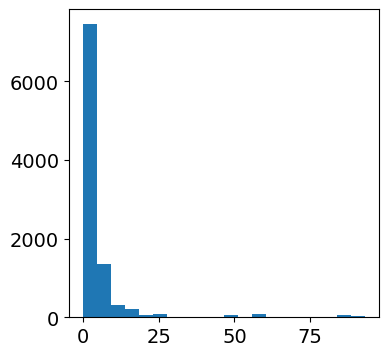

In [ ]:
df.loc[(df['Social_3'] < 100), 'Social_3'].\
    hist(figsize=(4,4), bins=20, grid=False);

In [ ]:
df['Social_3'].value_counts()

Social_3
0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
59       25
93       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: count, dtype: int64

Очень странный признак. 0 - это оценка или отсутствующие значения? Если отстутствующие значения - то их очень много. Пока что будем считать, что это оценка, и ничего менять не будем.

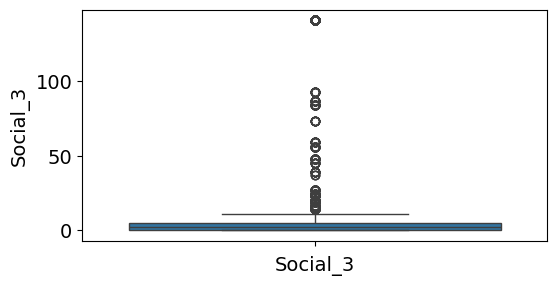

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

In [ ]:
df[df['Social_3'] > 50]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
30       89         50      2  39.435351   23.377687              7      9   
37    14591         43      2  43.701662   26.350358              5      5   
78     7758        156      1  39.248927   21.592325              7     13   
107    9970        159      3  61.809022   40.444725              6      2   
262    2173        181      2  62.198335   39.680729              5      7   
...     ...        ...    ...        ...         ...            ...    ...   
9923  16273         30      2  63.905356         NaN              1      6   
9936  15173         30      2  62.341347         NaN              1     19   
9962   4660        158      2  63.131655   41.867913              8      9   
9973  12590        115      2  48.201451   33.396431              8     15   
9974   2159         30      1  33.227093   32.639166              1      4   

      HouseFloor  HouseYear     Ecology_1 Ecology_2 Ecology_3  Social_1  \
30             9       1965  7.658515e-03         B         B        35   
37             9       1961  1.501689e-02         B         B        17   
78            17       2009  7.658515e-03         B         B        35   
107            9       1972  1.501689e-02         B         B        17   
262            9       1948  0.000000e+00         B         B        30   
...          ...        ...           ...       ...       ...       ...   
9923          25       1977  7.815280e-05         B         B        22   
9936          21       1977  7.815280e-05         B         B        22   
9962           8       1939  4.203159e-02         B         B        37   
9973          14       1972  1.800000e-09         B         B        16   
9974           4       2016  7.815280e-05         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
30        7077        56          2301            3       19       B   
37        3079        59          2890            0        8       B   
78        7077        56          2301            3       19       B   
107       3079        59          2890            0        8       B   
262       7538        87          4702            5        5       B   
...        ...       ...           ...          ...      ...     ...   
9923      6398       141          1046            3       23       B   
9936      6398       141          1046            3       23       B   
9962      6856        84          1940            2        5       B   
9973      3681        73          1815            2        5       B   
9974      6398       141          1046            3       23       B   

              Price  
30    283877.617142  
37    287056.012543  
78    254236.325086  
107   378581.541200  
262   541173.319391  
...             ...  
9923  189417.357268  
9936  174256.265798  
9962   87268.098968  
9973  197405.312185  
9974   65949.315881  

[424 rows x 20 columns]

Это не выбросы, это высокие оценки. Проблема в том, что очень много нулевых значений - это оценка или незаполненное значение? Так как социальные показатели показывают 2 других признака - Social_1 и Social_2 - можно попробовать убрать этот признак.

#### Healthcare_1

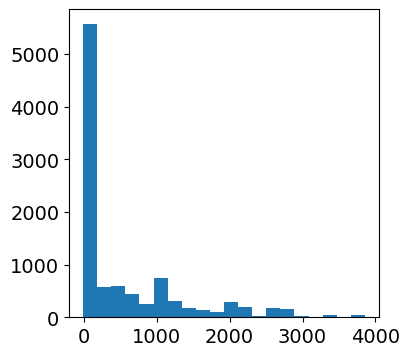

In [ ]:
df.loc[(df['Healthcare_1'] < 4000), 'Healthcare_1'].\
    hist(figsize=(4,4), bins=20, grid=False);

Очень много пропусков (половина).

In [ ]:
df.loc[df['Healthcare_1'] < 0, 'Healthcare_1'] = df['Healthcare_1'].median()

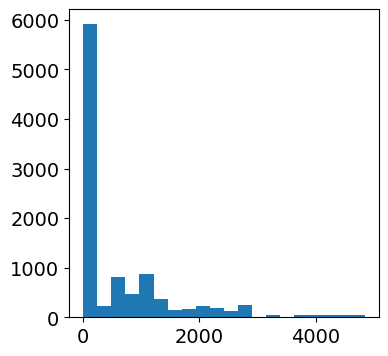

In [ ]:
df['Healthcare_1'].\
    hist(figsize=(4,4), bins=20, grid=False);

Пропусков половина, поэтому заменив их на медиану, мы сильно исказим данные. Этот столбец предлагается удалить.

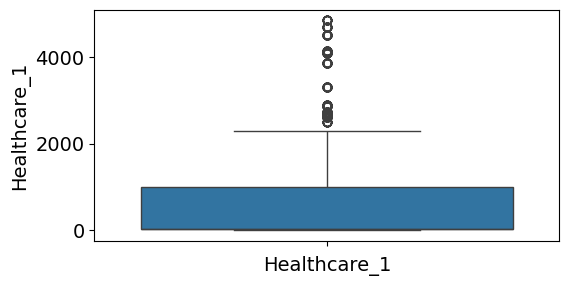

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Healthcare_1'], whis=1.5)

plt.xlabel('Healthcare_1')
plt.show()

Пропусков было половина, и мы их заполнили медианой. Теперь медиана находится в нуле или около нуля.

In [ ]:
df[df['Healthcare_1'] > 2000]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
4     10783         99      1   39.649192   23.776169              7     11   
15     2823         85      3   73.612225   53.892089              6      4   
20     8862          0      3  103.605292   47.799426             10     12   
30       89         50      2   39.435351   23.377687              7      9   
37    14591         43      2   43.701662   26.350358              5      5   
...     ...        ...    ...         ...         ...            ...    ...   
9924   3327        145      1   41.093702   20.643619              8     18   
9934   2548         53      1   34.972880   18.919588              6      9   
9952   4490        105      2   52.320284   32.839770              8      9   
9959  10361          0      1   32.416925   19.257869              6      6   
9970   1612         84      3   53.430413   34.603687              6      8   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4             12       1976   0.012339         B         B        35   
15             9       1979   0.037178         B         B        52   
20            17       2002   0.319809         B         B        25   
30             9       1965   0.007659         B         B        35   
37             9       1961   0.015017         B         B        17   
...          ...        ...        ...       ...       ...       ...   
9924          17       1998   0.246032         B         A        22   
9934           9       1976   0.313925         B         B        22   
9952          14       1979   0.040243         B         B        25   
9959           5       1963   0.319809         B         B        25   
9970           9       1970   0.149666         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
4         5776         1          2078            2        4       B   
15       11217         1          2300            1        7       B   
20        4756        16          2857            5        8       B   
30        7077        56          2301            3       19       B   
37        3079        59          2890            0        8       B   
...        ...       ...           ...          ...      ...     ...   
9924      3151         4          2715            3        3       B   
9934      4625        11          3855            2       10       B   
9952      3478        11          2729            3        1       B   
9959      4756        16          2857            5        8       B   
9970      4789         2          4087            4        1       B   

              Price  
4     150226.531644  
15     89084.327876  
20    521919.057400  
30    283877.617142  
37    287056.012543  
...             ...  
9924  174921.829928  
9934  177090.199079  
9952  325950.624774  
9959  125579.315184  
9970  220804.817110  

[891 rows x 20 columns]

Это не выбросы, это высокие оценки. Проблема в том, что пропущенных значений - половина. Хочется удалить этот столбец, особенно когда есть Healthcare_2.

#### Healthcare_2

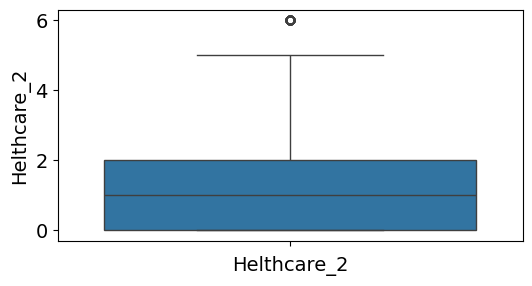

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Helthcare_2'], whis=1.5)

plt.xlabel('Helthcare_2')
plt.show()

In [ ]:
df[df['Helthcare_2'] > 5]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
23     6641         54      3  118.907612         NaN              0      2   
195    4645         54      2   76.312851         NaN              0     14   
264   15853         54      3   58.703834   41.700194              5      3   
312    7383         84      2   38.012225   27.777619              5      3   
568   15542         84      2   65.185448   39.046962              6      4   
...     ...        ...    ...         ...         ...            ...    ...   
9701   9022          0      2   60.789975         NaN              1      4   
9721    396         54      3  110.119100  110.333763              1      8   
9785  16508         81      1   49.754370   17.700077             10     18   
9921  11426          0      2   56.724377   32.602235              8      9   
9977  10650         54      2   38.599779   22.740244              6      2   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
23            13       1977   0.006076         B         B        30   
195           13       1977   0.006076         B         B        30   
264            5       1967   0.006076         B         B        30   
312            9       1965   0.006076         B         B        30   
568            5       1958   0.006076         B         B        30   
...          ...        ...        ...       ...       ...       ...   
9701          17       1977   0.006076         B         B        30   
9721           1       2015   0.006076         B         B        30   
9785          17       2009   0.006076         B         B        30   
9921          12       1982   0.006076         B         B        30   
9977          12       1970   0.006076         B         B        30   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
23        5285         0           645            6        6       B   
195       5285         0           645            6        6       B   
264       5285         0           645            6        6       B   
312       5285         0           645            6        6       B   
568       5285         0           645            6        6       B   
...        ...       ...           ...          ...      ...     ...   
9701      5285         0           645            6        6       B   
9721      5285         0           645            6        6       B   
9785      5285         0           645            6        6       B   
9921      5285         0           645            6        6       B   
9977      5285         0           645            6        6       B   

              Price  
23    571069.052600  
195   466730.805333  
264   246473.438829  
312   219003.735652  
568   272357.510062  
...             ...  
9701  162985.116572  
9721  491296.245173  
9785  173432.025953  
9921  164687.824957  
9977  174497.101781  

[99 rows x 20 columns]

Это не выброс, это просто самая высокая оценка. Показатели Social_1, Social_2 и Shops_1 тоже имеют хорошие оценки. Значит дом находится в районе с развитой инфраструктурой.

#### Shops_1

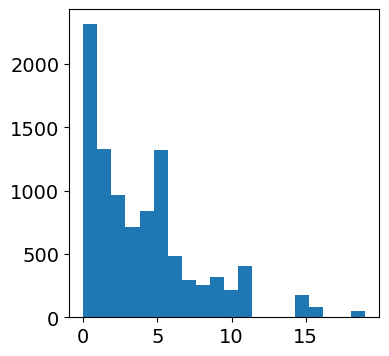

In [ ]:
df.loc[df['Shops_1'] < 20, 'Shops_1'].\
    hist(figsize=(4,4), bins=20, grid=False);

Выглядит нормально, но много значений - нулевые. Непонятно, это оценка или пропущенные значения. Пока что будем считать, что это оценка, и ничего менять не будем.

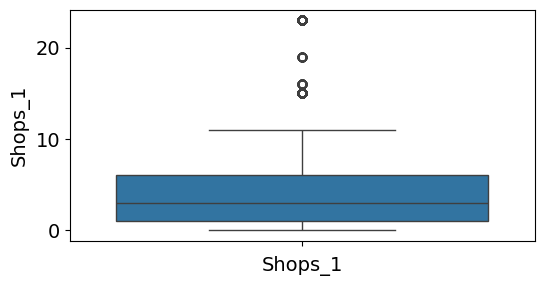

In [ ]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

In [ ]:
df[df['Shops_1'] > 15]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
1     15053         41      3  65.683640   40.049543              8      7   
30       89         50      2  39.435351   23.377687              7      9   
62     7619         47      2  54.787324   33.512143              8      1   
68     1063         77      1  42.678844   23.918634              8     14   
78     7758        156      1  39.248927   21.592325              7     13   
...     ...        ...    ...        ...         ...            ...    ...   
9923  16273         30      2  63.905356         NaN              1      6   
9936  15173         30      2  62.341347         NaN              1     19   
9969   9470         77      3  50.623669   37.129826              6      4   
9974   2159         30      1  33.227093   32.639166              1      4   
9981  13352         77      2  53.537800   30.979054              8     10   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1              9       1978   0.000070         B         B        46   
30             9       1965   0.007659         B         B        35   
62            12       1978   0.000070         B         B        46   
68            12       1983   0.000070         B         B        46   
78            17       2009   0.007659         B         B        35   
...          ...        ...        ...       ...       ...       ...   
9923          25       1977   0.000078         B         B        22   
9936          21       1977   0.000078         B         B        22   
9969           9       1976   0.000070         B         B        46   
9974           4       2016   0.000078         B         B        22   
9981          12       1977   0.000070         B         B        46   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1        10309         1           240            1       16       B   
30        7077        56          2301            3       19       B   
62       10309         1           240            1       16       B   
68       10309         1           240            1       16       B   
78        7077        56          2301            3       19       B   
...        ...       ...           ...          ...      ...     ...   
9923      6398       141          1046            3       23       B   
9936      6398       141          1046            3       23       B   
9969     10309         1           240            1       16       B   
9974      6398       141          1046            3       23       B   
9981     10309         1           240            1       16       B   

              Price  
1     300009.450063  
30    283877.617142  
62    100471.952613  
68    179784.473334  
78    254236.325086  
...             ...  
9923  189417.357268  
9936  174256.265798  
9969  229768.874305  
9974   65949.315881  
9981  242356.408174  

[377 rows x 20 columns]

Не выбросы, а высокие оценки.

#### Корреляции признаков


Оставила только сильно коррелирующие признаки

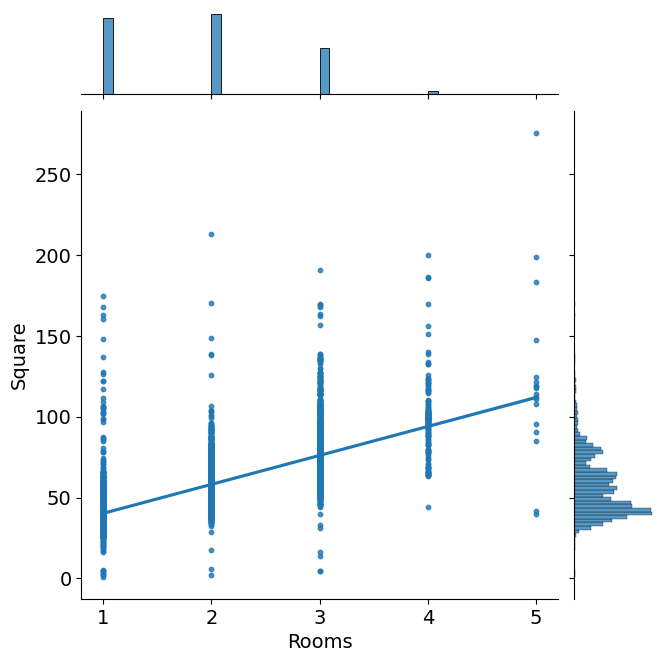

In [ ]:
grid = sns.JointGrid(x='Rooms', y='Square', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Наблюдается корреляция. Чем больше комнат, тем больше площадь - логично.

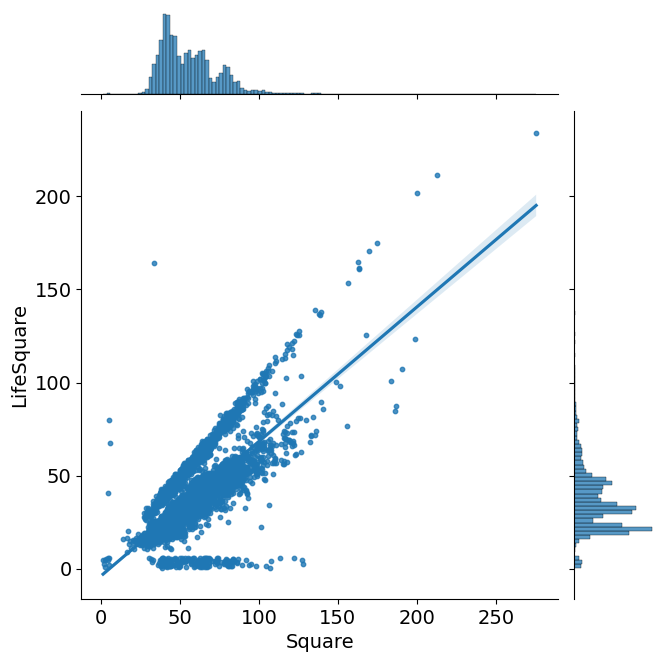

In [ ]:
grid = sns.JointGrid(x='Square', y='LifeSquare', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Сильная корреляция, как и должно быть. Видны выбросы LifeSquare == 0, Square == 0.

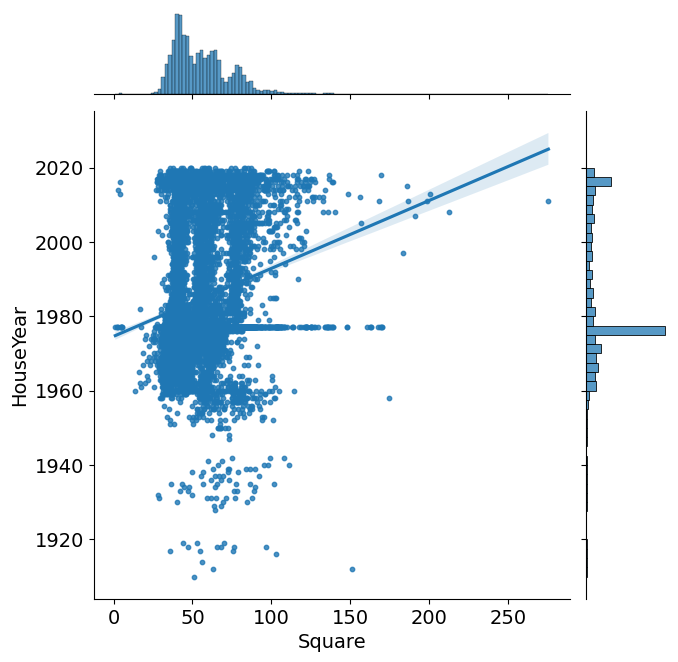

In [ ]:
grid = sns.JointGrid(x='Square', y='HouseYear', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Наблюдается корреляция.

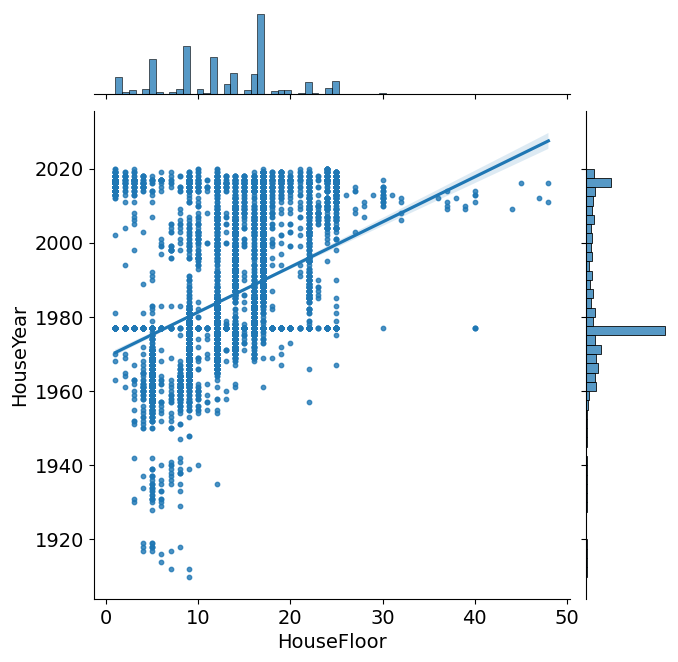

In [ ]:
grid = sns.JointGrid(x='HouseFloor', y='HouseYear', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Есть сильная корреляция. Раньше не строили таких высотных домов, как сейчас.

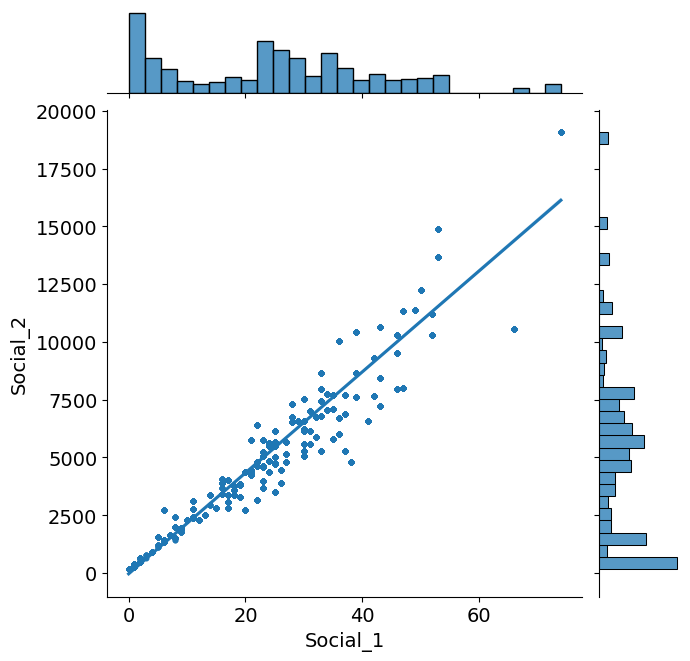

In [ ]:
grid = sns.JointGrid(x='Social_1', y='Social_2', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Наблюдается сильная корреляция. Значит, признаки похожи и можно выбрать один из них.

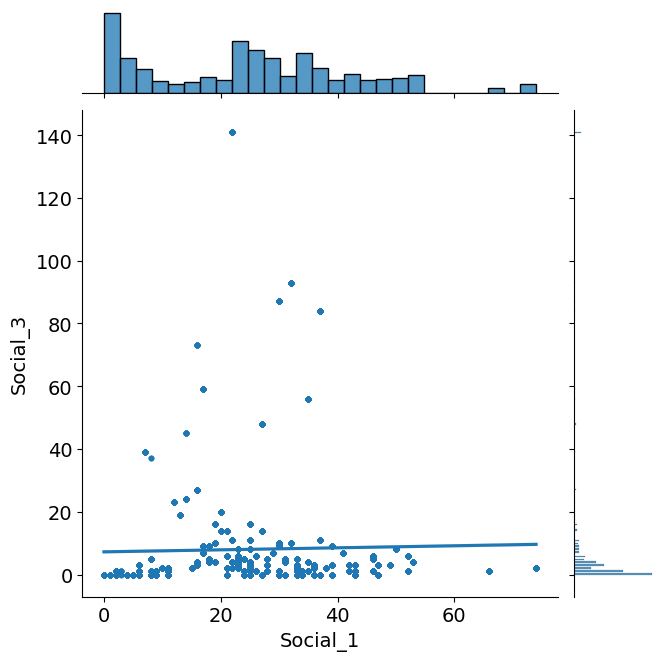

In [ ]:
grid = sns.JointGrid(x='Social_1', y='Social_3', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Корреляция отсутствует. В Social_3 много значений 0.

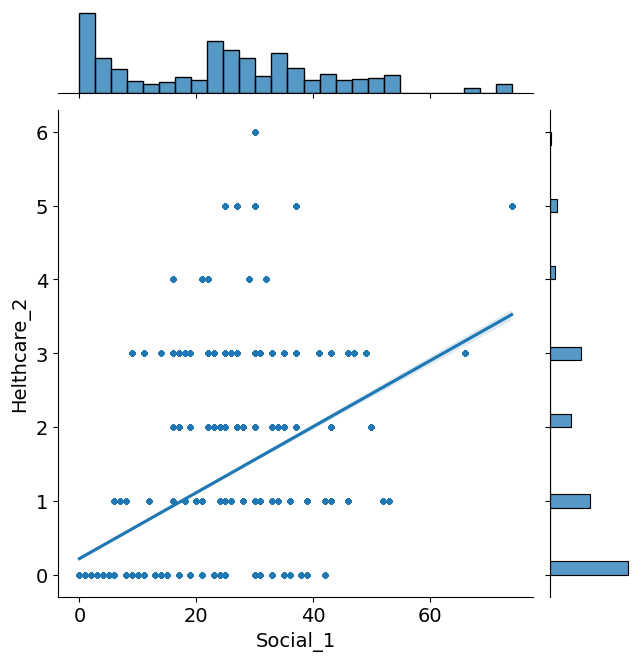

In [ ]:
grid = sns.JointGrid(x='Social_1', y='Helthcare_2', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Присутствует сильная корреляция. В районе с хорошими социальными показателями хорошие показатели охраны здоровья.

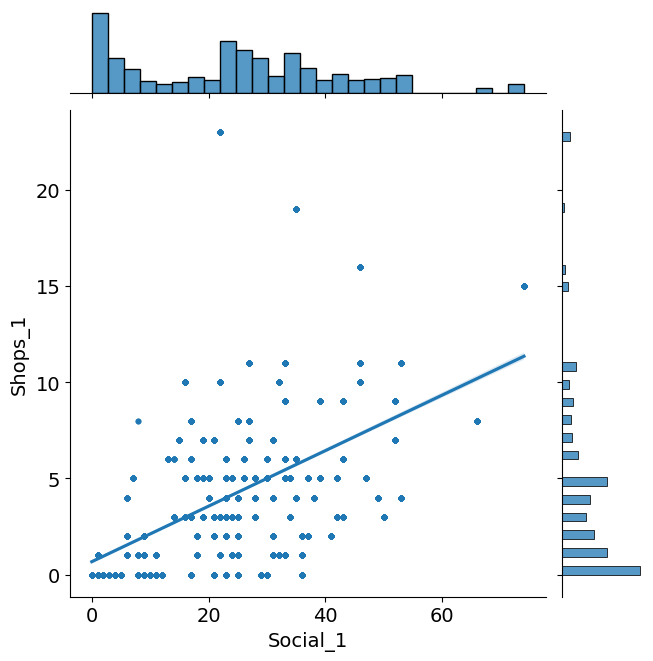

In [ ]:
grid = sns.JointGrid(x='Social_1', y='Shops_1', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Присутствует корреляция. В районе с хорошими социальными показателями хорошая торговая инфраструктура

#### Выводы по количественным признакам
За подробным объяснением можно развернуть соответствующую ячейку выше
* Rooms: =0, >5 - выбросы.
* Square: <11, >300 - выбросы (поделить (те, у которых >300) LifeSquare и Square на 10, и тогда они станут валидными данными)
* LifeSquare: =0, >250, LifeSquare/Square > 2 - выбросы
* KitchenSquare: <=0 и KitchenSquare / Square > 0.5 - выбросы
* HouseFloor: =0, >95 - выбросы
* HouseYear: <1910, >2020 - выбросы. У отрицательных значений убрать знак.
* Social_1 и Social_2 - хорошие признаки, можно выбрать один из них (лучше Social_1).
* Social_3: Очень много нулевых значений. Попробовать удалить признак?
* Healthcare_1: половина - пропущенные данные. Удалить признак, т.к. есть Healthcare_2
* Остальные признаки хорошие

### 1.2.2. Категориальные признаки

In [ ]:
df_cat_features = df.select_dtypes(include=['category'])
df_cat_features.head()

DistrictId Ecology_2 Ecology_3 Shops_2
0         35         B         B       B
1         41         B         B       B
2         53         B         B       B
3         58         B         B       B
4         99         B         B       B

In [ ]:
df['DistrictId'].value_counts()

DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
174      1
205      1
207      1
117      1
209      1
Name: count, Length: 205, dtype: int64

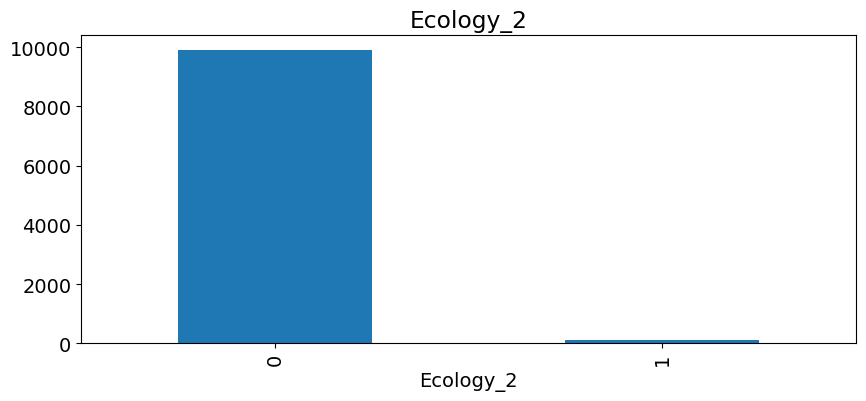

In [ ]:
values = df['Ecology_2'].value_counts()

plt.figure(figsize=(10, 4))
values.plot(kind='bar')
plt.title('Ecology_2')

plt.show()

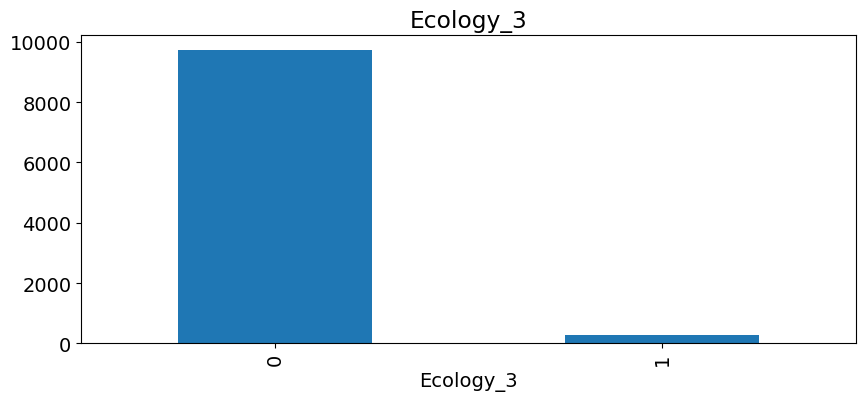

In [ ]:
values = df['Ecology_3'].value_counts()

plt.figure(figsize=(10, 4))
values.plot(kind='bar')
plt.title('Ecology_3')

plt.show()

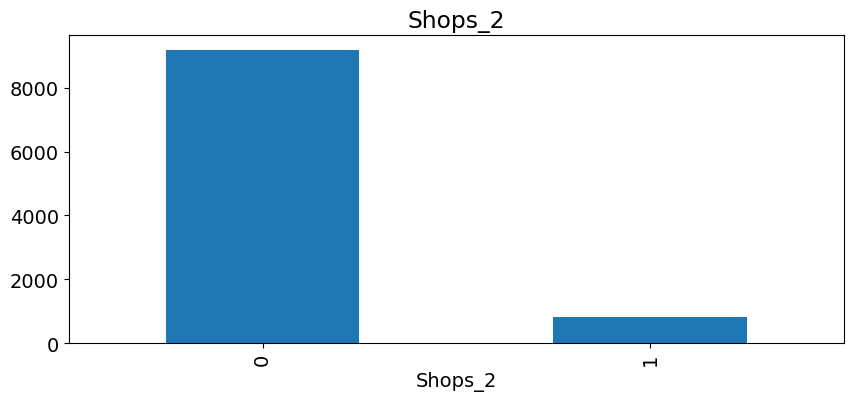

In [ ]:
values = df['Shops_2'].value_counts()

plt.figure(figsize=(10, 4))
values.plot(kind='bar')
plt.title('Shops_2')

plt.show()

Все три признака можно сделать бинарными (значения 0 и 1)

In [ ]:
df['Ecology_2'] = (df['Ecology_2'] == 'A').astype('int8')
df['Ecology_3'] = (df['Ecology_3'] == 'A').astype('int8')
df['Shops_2'] = (df['Shops_2'] == 'A').astype('int8')

In [ ]:
df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35      2  47.981561   29.442751              6      7   
1  15053         41      3  65.683640   40.049543              8      7   
2   4765         53      2  44.947953   29.197612              0      8   
3   5809         58      2  53.352981   52.731512              9      8   
4  10783         99      1  39.649192   23.776169              7     11   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0           9       1969   0.089040          0          0        33      7976   
1           9       1978   0.000070          0          0        46     10309   
2          12       1968   0.049637          0          0        34      7759   
3          17       1977   0.437885          0          0        23      5735   
4          12       1976   0.012339          0          0        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  
0         5            30            0       11        0  184966.930730  
1         1           240            1       16        0  300009.450063  
2         0           229            1        3        0  220925.908524  
3         3          1084            0        5        0  175616.227217  
4         1          2078            2        4        0  150226.531644

In [ ]:
df.dtypes

Id                 object
DistrictId       category
Rooms                int8
Square            float64
LifeSquare        float64
KitchenSquare        int8
Floor                int8
HouseFloor           int8
HouseYear           int16
Ecology_1         float32
Ecology_2            int8
Ecology_3            int8
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1        int16
Helthcare_2          int8
Shops_1              int8
Shops_2              int8
Price             float64
dtype: object

### 1.2.3. Матрица корреляций

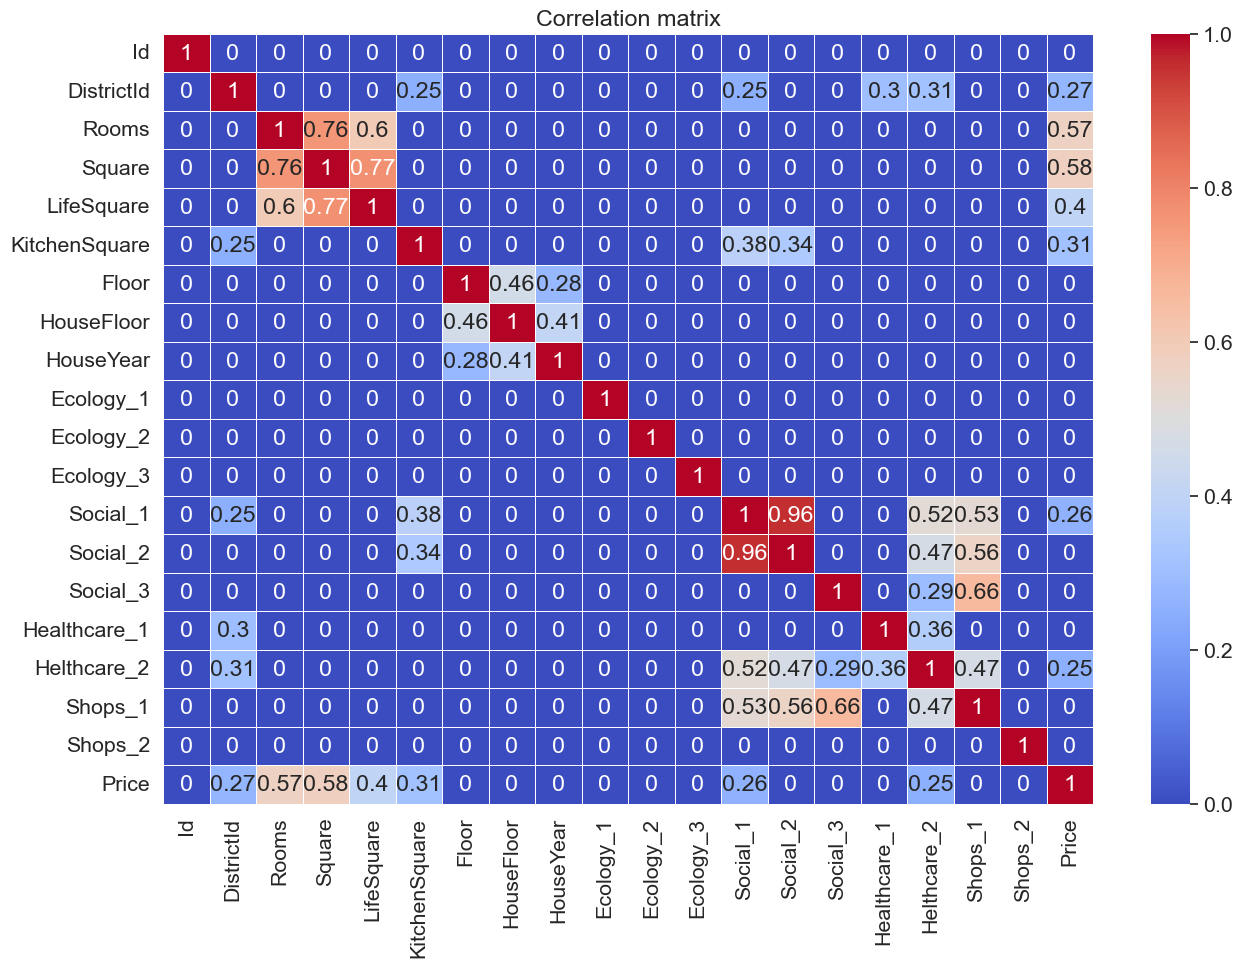

In [ ]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.25] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Можем заметить, что цена больше всего зависит от таких признаков, как Rooms, Square, LifeSquare, KitchenSquare, Social_1 и Helthcare_2. Остальные признаки не оказывают значительного влияния на цену. Можно попробовать разделить их на категории.

### Выводы по анализу признаков
За подробным объяснением можно развернуть соответствующую категорию выше. Жирным выделены самые важные признаки.
* **Rooms**: =0, >5 - выбросы.
* **Square**: <11, >300 - выбросы (поделить их (у тех, где >300) LifeSquare и Square на 10, и тогда они станут валидными данными)
* **LifeSquare**: =0, >250, LifeSquare/Square > 2 - выбросы
* **KitchenSquare**: <=0 и KitchenSquare / Square > 0.5 - выбросы
* HouseFloor: =0, >95 - выбросы
* HouseYear: <1910, >2020 - выбросы. У отрицательных значений убрать знак.
* **Social_1** и Social_2 - хорошие признаки, можно выбрать один из них (лучше Social_1).
* Social_3: Очень много нулевых значений. Попробовать удалить признак?
* Healthcare_1: половина - пропущенные данные. Удалить признак, т.к. есть **Healthcare_2**
* Остальные количественные признаки хорошие

* Признаки Ecology_2, Ecology_3 и Shops_2 сделать бинарными

## 1.3. Анализ зависимости таргета от признаков

### 1.3.1. Количественные признаки

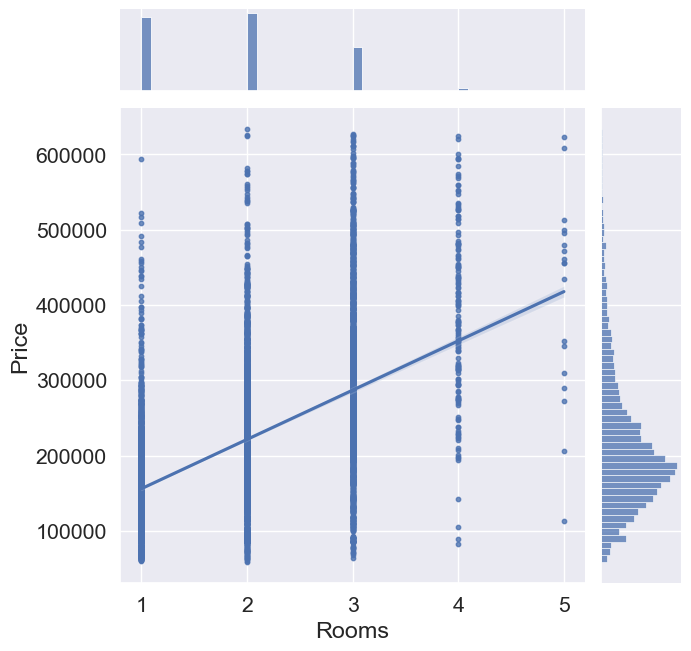

In [ ]:
grid = sns.JointGrid(x='Rooms', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Видна корреляция. Чем больше комнат - тем выше цена.

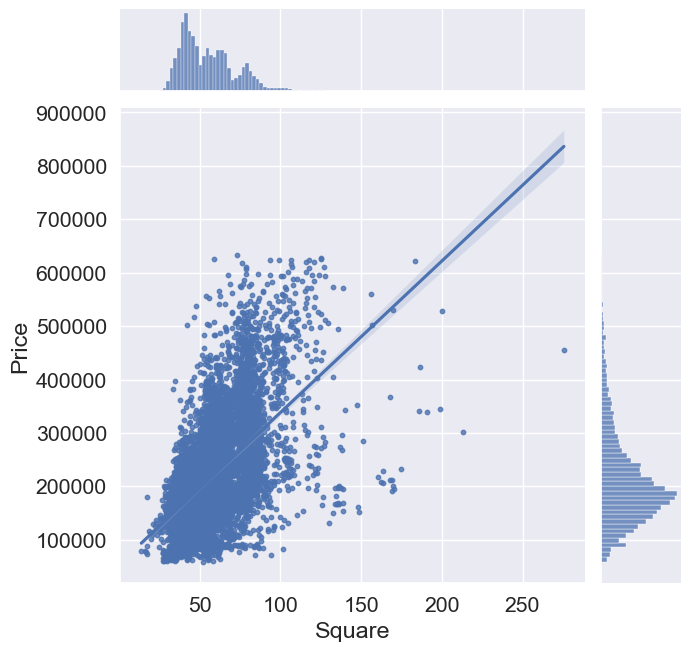

In [ ]:
grid = sns.JointGrid(x='Square', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Сильная корреляция. Чем больше комнат - тем выше цена.

LifeSquare и KitchenSquare - признаки, зависящие от Square, поэтому цена будет также зависеть и от них.

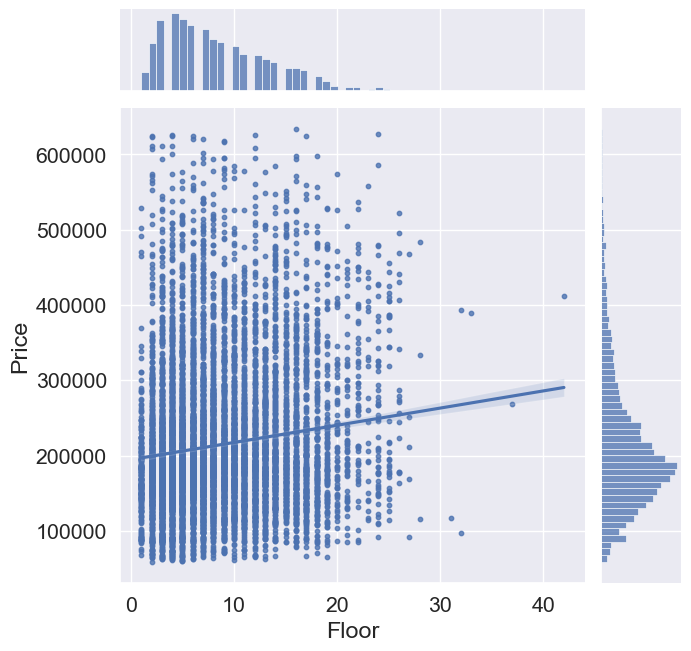

In [ ]:
grid = sns.JointGrid(x='Floor', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Слабая корреляция. Чем выше этаж, тем выше цена.

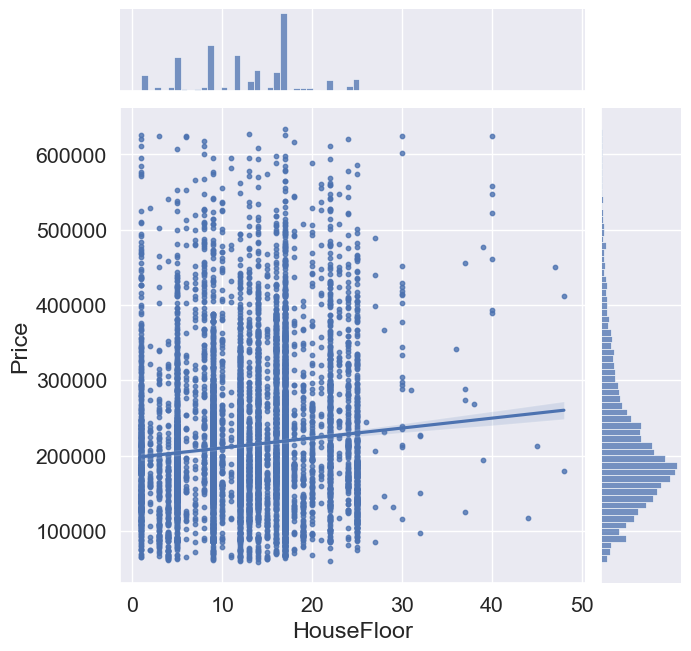

In [ ]:
grid = sns.JointGrid(x='HouseFloor', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Корреляции почти нет.

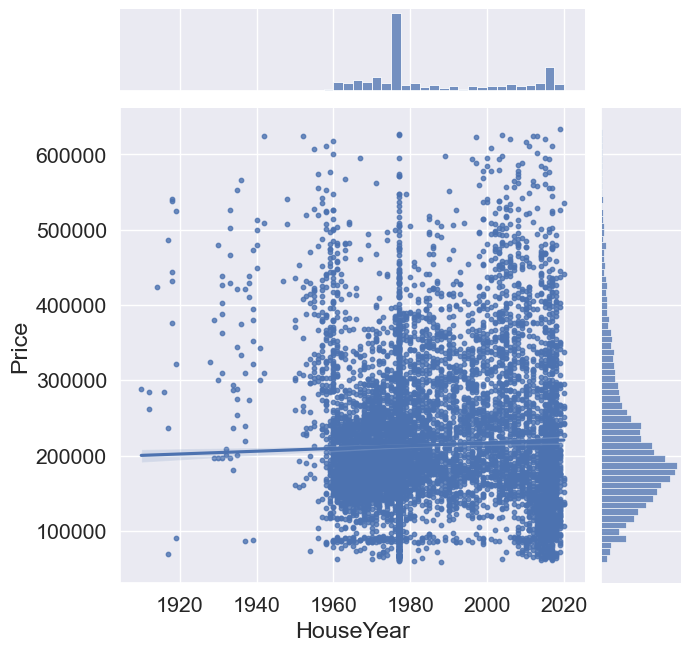

In [ ]:
grid = sns.JointGrid(x='HouseYear', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Корреляции нет. Судя по графику, Цена не зависит от года постройки дома.

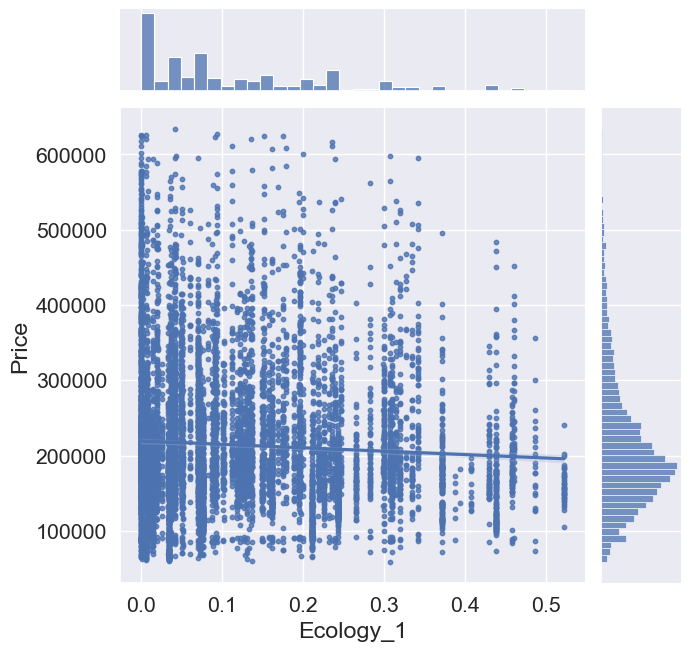

In [ ]:
grid = sns.JointGrid(x='Ecology_1', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Корреляции нет.

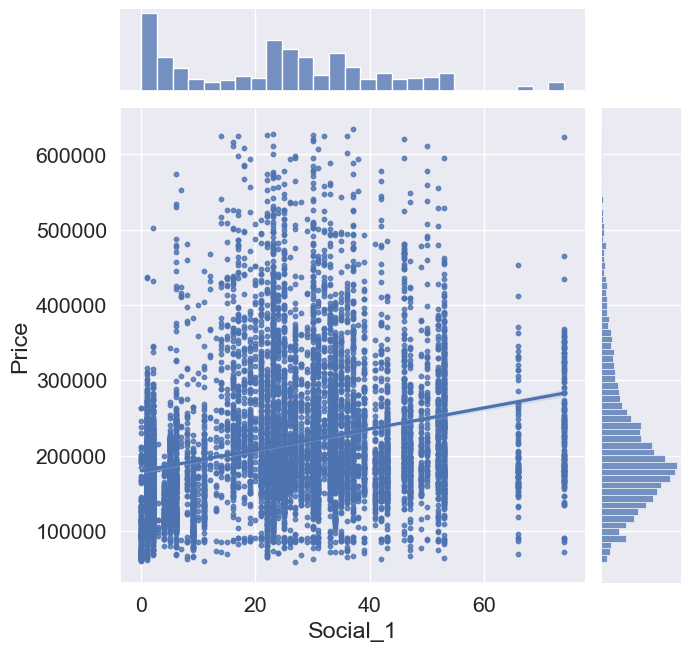

In [ ]:
grid = sns.JointGrid(x='Social_1', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Слабая корреляция. Чем лучше социальный показатель, тем выше цена.

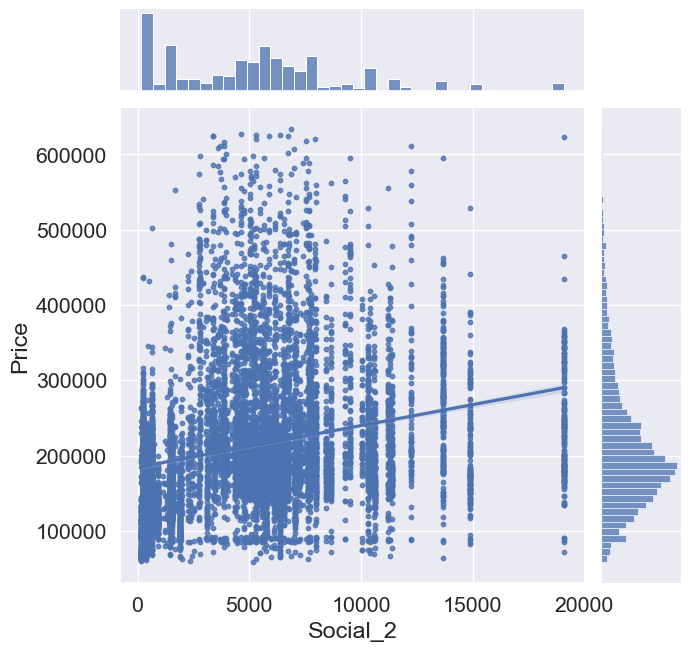

In [ ]:
grid = sns.JointGrid(x='Social_2', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

То же самое. Чем лучше социальный показатель, тем выше цена. Признаки Social_1 и Social_2 очень похожи.

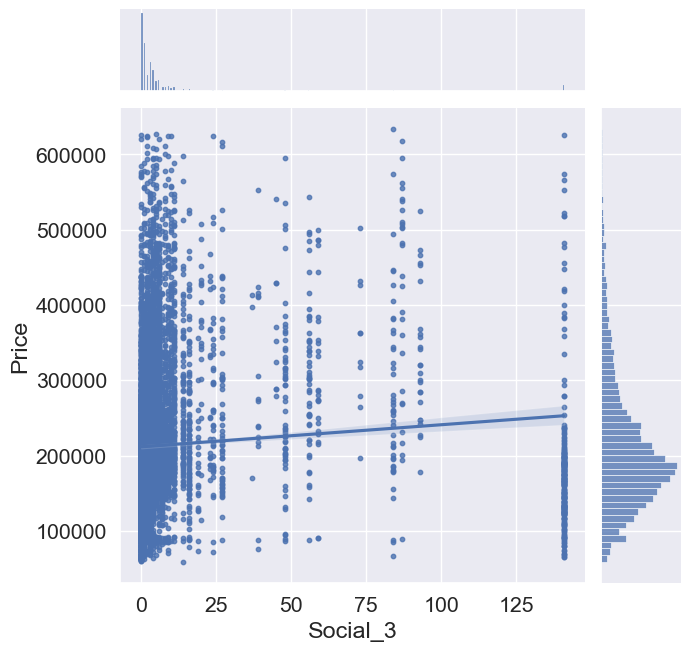

In [ ]:
grid = sns.JointGrid(x='Social_3', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Корреляции почти нет.

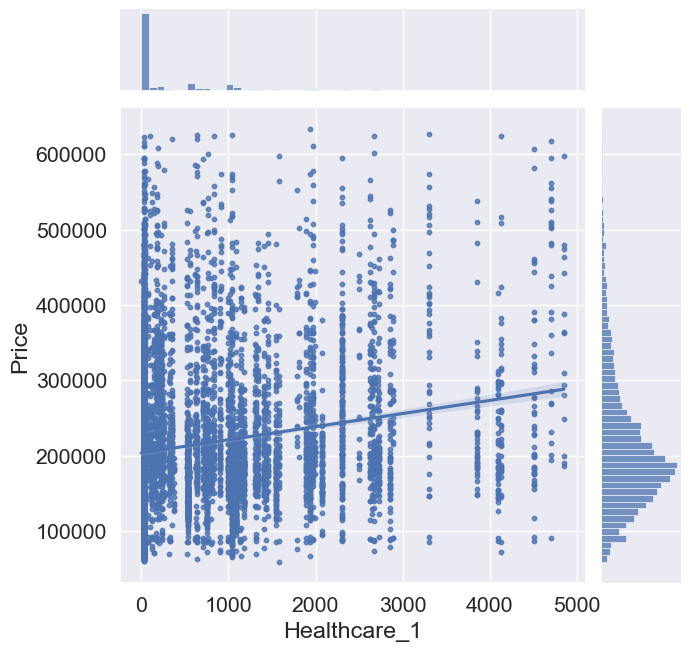

In [ ]:
grid = sns.JointGrid(x='Healthcare_1', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Слабая корреляция. Чем лучше показатели охраны здоровья, тем выше цена.

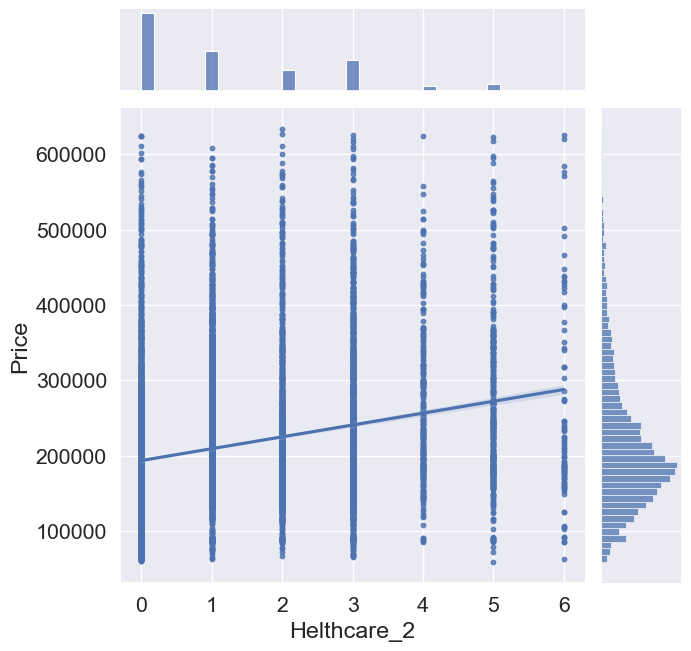

In [ ]:
grid = sns.JointGrid(x='Helthcare_2', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

То же самое. Чем лучше показатели охраны здоровья, тем выше цена. Но у Healthcare_2 намного меньше пропущенных значений.

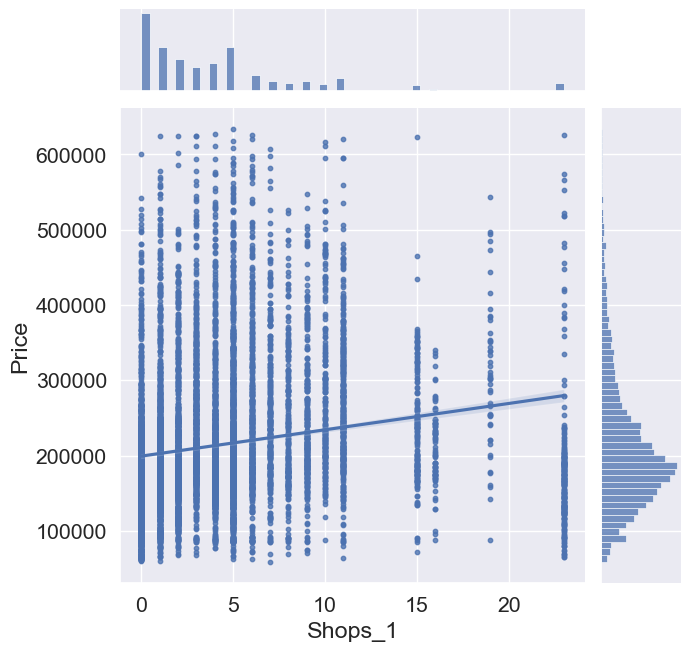

In [ ]:
grid = sns.JointGrid(x='Shops_1', y='Price', data=df)
grid = grid.plot_joint(sns.regplot, scatter_kws={'s': 10})
grid = grid.plot_marginals(sns.histplot)
grid.fig.set_figwidth(7)
grid.fig.set_figheight(7)

plt.show()

Слабая корреляция. Чем лучше показатели торговой инфраструктуры, тем выше цена.

### 1.3.2. Категориальные/бинарные признаки

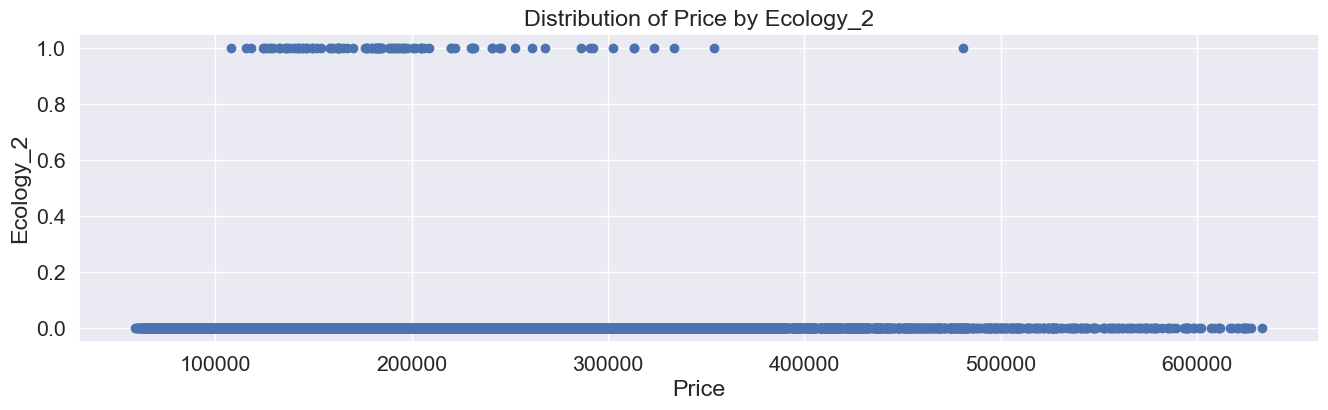

In [ ]:
plt.figure(figsize=(16, 4))

plt.scatter(df['Price'], df['Ecology_2'])

plt.xlabel('Price')
plt.ylabel('Ecology_2')
plt.title('Distribution of Price by Ecology_2')
plt.show()

Не видно, чтобы хорошие показатели в Ecology_2 как-то влияли на цену.

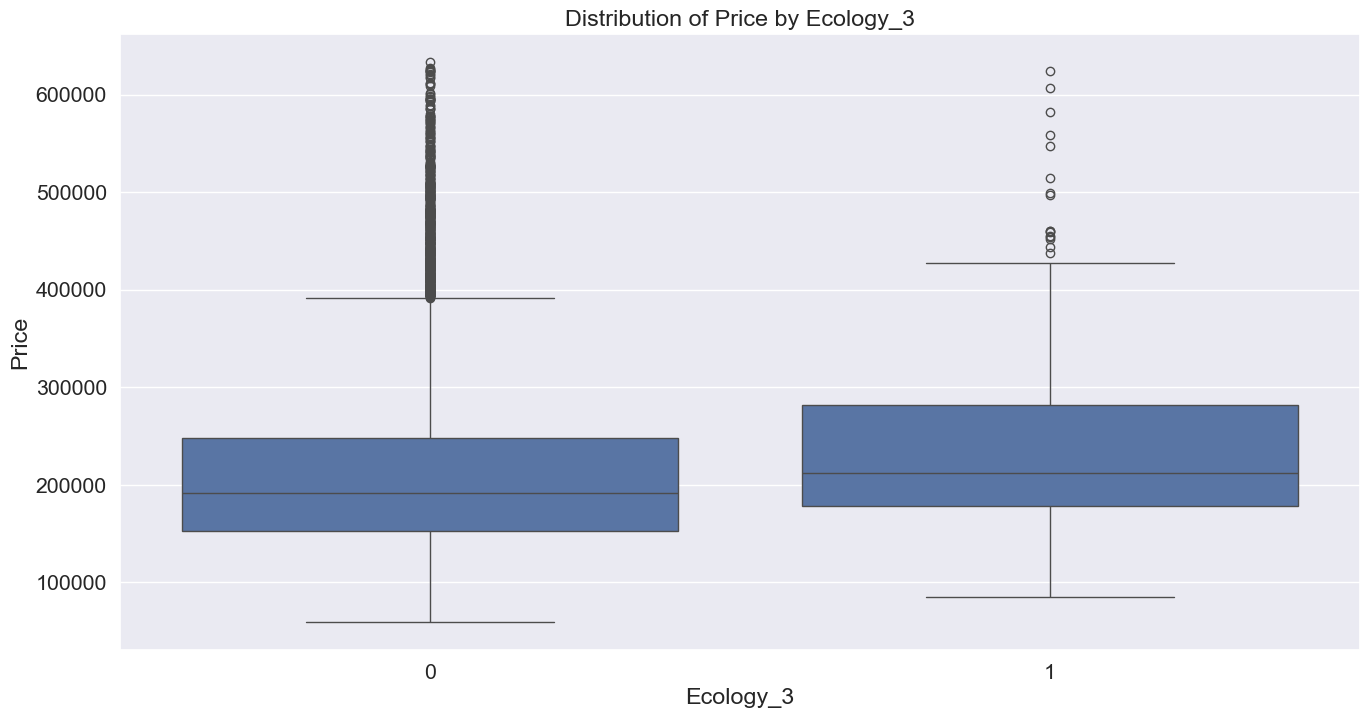

In [ ]:
plt.figure(figsize=(16, 8))


sns.boxplot(x=df['Ecology_3'], y=df['Price'], whis=1.5)

plt.xlabel('Ecology_3')
plt.ylabel('Price')
plt.title('Distribution of Price by Ecology_3')
plt.show()

Видно, что стоимость квартиры выше, если показатель Ecology_3 == 1.

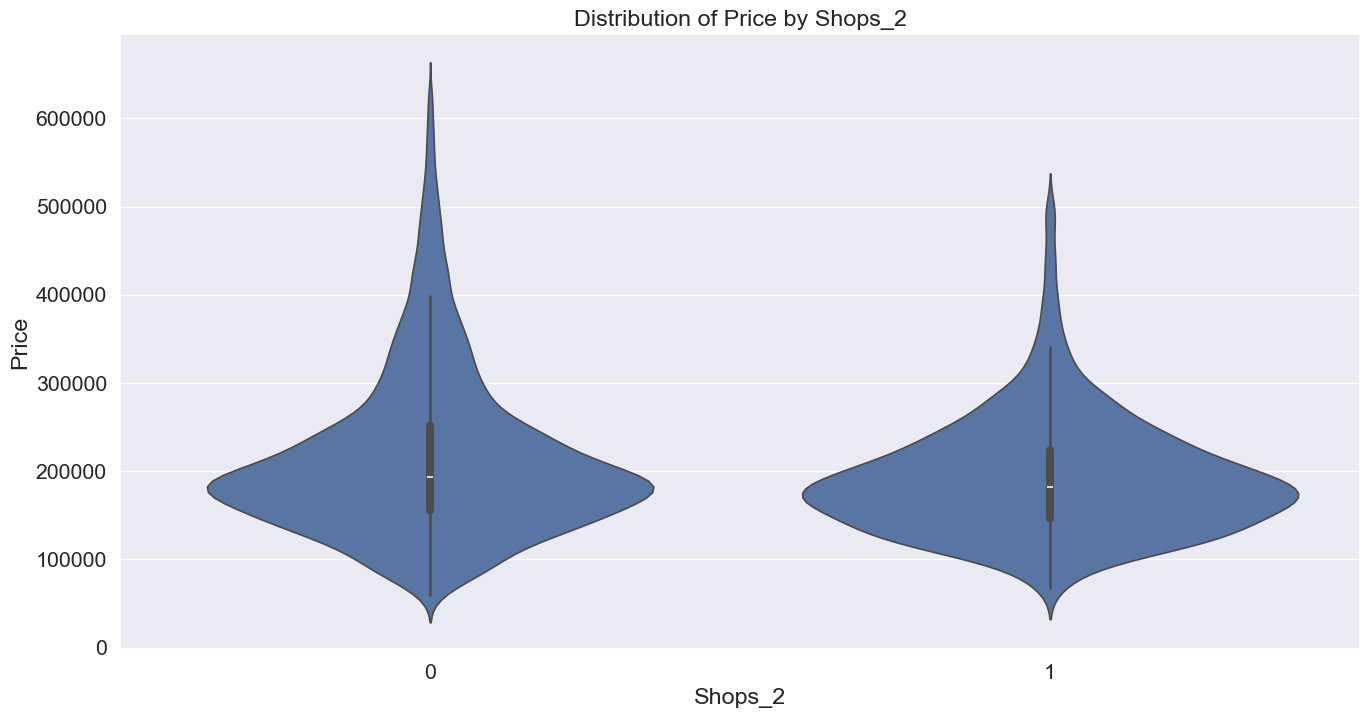

In [ ]:
plt.figure(figsize=(16, 8))

sns.violinplot(x=df['Shops_2'], y=df['Price'])

plt.xlabel('Shops_2')
plt.ylabel('Price')
plt.title('Distribution of Price by Shops_2')
plt.show()

Не видно, чтобы хороший показатель в Shops_2 как-то влиял на стоимость квартиры.

Выводы по бинарным признакам:
* Ecology_2 - не влияет на цену
* Ecology_3 - влияет на цену
* Shops_2 - не влияет на цену

# Выводы по анализу данных


За подробным объяснением можно развернуть соответствующую категорию выше. Жирным выделены самые важные признаки.
* **Rooms**: =0, >5 - выбросы.
* **Square**: <11, >300 - выбросы (поделить их (у тех, где >300) LifeSquare и Square на 10, и тогда они станут валидными данными)
* **LifeSquare**: =0, >250, LifeSquare/Square > 2 - выбросы
* **KitchenSquare**: <=0 и KitchenSquare / Square > 0.5 - выбросы
* HouseFloor: =0, >95 - выбросы
* HouseYear: <1910, >2020 - выбросы. У отрицательных значений убрать знак.
* **Social_1** и Social_2 - хорошие признаки, можно выбрать один из них (лучше Social_1).
* Social_3: Очень много нулевых значений. Попробовать удалить признак.
* Healthcare_1: половина - пропущенные данные. Удалить признак, т.к. есть **Healthcare_2**
* Остальные количественные признаки хорошие

* Признаки Ecology_2, Ecology_3 и Shops_2 сделать бинарными
  
  После анализа бинарных признаков выявлено, что:
* Ecology_2 и Shops_2 не влияют на стоимость, поэтому можно попробовать их выбросить
* Ecology_3 немного влияет на стоимость, этот признак оставляем

Доп: в этом наборе данных не хватает одного очень важного признака - состояние квариры :( Это сильно влияет на стоимость квартиры, и у нас нет этой информации :(

# 2. Предобработка данных

##  Готовый пайплайн предобработки находится в пункте 2.7. Пункты 2.1 - 2.6 - объяснение действий в пайплайне, их запускать не нужно.

## 2.0. Загрузка данных

In [ ]:
df = pd.read_csv(DATASET_PATH, sep=',')
df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

## 2.1. Описание действий с признаками


Основываясь на анализе данных (см. пункт 1):

0. **DistrictId** - меняем на категориальный признак, потому что цена не зависит от id района.
1. **Rooms**: 0 комнат не может быть. Если ещё Square < 11 и LifeSquare < 11 (слишком малая площадь для квартиры) - то важных информативных данных в этой строке нет, удалить эту строчку (она одна в train.csv). Остальные нули заменяем в зависимости от площади. Если площадь от 11 и до 48.125 - заменить на 1. Если от 48.125 и до 66.625 - заменить на 2. От 66.625 до 88.04 - на 3. От 88.04 до 107.375 - на 4. Всё, что выше, - 5. (Значения площади рассчитаны на основании df.groupby('Rooms')['Square'].median() - середины между медианами взяты за границы между комнатностями. Я посчитала, что лучше отталкиваться от площади, чем заменять на медиану по всем значениям комнатности.)
   Также Rooms не может быть 6, 10 и 19 (у них слишком малая площадь для этого: средняя площадь 6-тикомнатной квартиры - 150 кв. м.) Заменить по принципу выше.
2. **Square**: не может быть менее 11. Если LifeSquare принимает адекватные значения (> 11), то можно рассчитать Square на основании LifeSquare (LifeSquare / 0.7, где 0.7 - средняя доля жилой площади от общей площади в квартирах). В остальных случаях можно заменить на медиану в зависимости от кол-ва комнат (df.groupby('Rooms')['Square'].median()).
   Если у квартиры площадь > 175, а цена < 244964, то это неправильно заполненное значение. Если посмотреть на них, то у них значения Square 400 - 600 кв м. Если поделить их на 10, то значение Square приходит в норму, соответствующую комнатности и стоимости (что можно посмотреть через df.groupby('Rooms')['Square'].median() и df.groupby('Rooms')['Price'].median()).
3. **LifeSquare**. Много пропущенных значений (около 21%, не учитывая неправильные значения). Можно попробовать удалить этот столбец, так как жилая площадь всё равно зависит от общей площади, а при выборе квартиры покупатели ориентируются на общую площадь. Но сначала попробуем заполнить пропущенные значения. Там, где значения пропущены, можно заполнить по формуле Square * 0.7 - средняя доля жилой площади в квартирах (не на основании данного датасэта). Неправильные значения: Там, где LifeSquare < 7 (204 наблюдения), заменить по той же формуле. Если доля жилой площади <= 25% от общей площади, заменить по той же формуле. Если LifeSquare > 1000, заменить по той же формуле. Если LifeSquare > 150 и Price < 171290, заменить по той же формуле. Много значений, которые невозможно определить в правильные или неправильные, поэтому кажется, что столбец очень грязный, и хочется удалить этот столбец.
4. **KitchenSquare**. У 699 наблюдений площадь кухни <= 0. У 3159 наблюдений (31.5%!) площадь кухни <= 1 (при кол-ве комнат, например, 2 и площади = 40-50).  Можно попробовать заменить по формуле Square * 0.125 - средняя доля кухни от общей площади квартиры. А можно попробовать удалить этот признак, потому что ошибочных данных очень много. Если в однокомнатной квартире иногда может быть площадь кухни 3 м, то в трёхкомнатной не может. Проверять каждое наблюдение - очень трудозатратно. Пока что заменим те значения, где площадь кухни <= 1, и где доля кухни > 50% от общей площади по формуле Square * 0.125.
5. **Floor** - всё хорошо.
6. **HouseFloor**. У 1825 наблюдений HouseFloor < Floor (то есть указано этажей в доме меньше, чем этаж квартиры). Заменить здесь HouseFloor на значение Floor. Самая высокая жилая многоэтажка в России - 95 этажей, поэтому всё, что выше, - заменить на значение Floor.
7. **HouseYear**. У отрицательных значений убрать минус. Года, которые больше 2020, заменить на медиану.
8. **Ecology_1** - выглядит нормально, но непонятно, значения 0.0 - это оценка или пропущенные значения? Пока предположим, это оценка.
9. **Ecology_2**, **Ecology_3** - Ecology_2 не влияет на стоимость, а Ecology_3 - влияет, поэтому из этих признаков лучше выбрать Ecology_3.
10. **Social_1**, **Social_2** - хорошие признаки, лучше выбрать Social_1.
11. **Social_3** - В этом столбце 3000 наблюдений имеют значение 0. Непонятно, это оценка 0 или значения отсутствуют. Можно попробовать удалить этот признак.
12. **Healthcare_1**. Пропущенных значений - половина. Его можно удалить.
13. **Healthcare_2**. - хороший признак.
14. **Shops_1** - выглядит нормально, но непонятно, значения 0 - это оценка или пропущенные значения? Пока предположим, это оценка.
15. **Shops_2** - не влияет на стоимость, можно попробовать удалить этот признак.
16. **Price** - выглядит нормально, явных выбросов не заметила.

## 2.2. Приведение типов данных

In [ ]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [ ]:
# Изменим типы данных
df['Id'] = df['Id'].astype(str)    # Не количественная переменная
df['DistrictId'] = df['DistrictId'].astype(str)    # Категориальный признак
df['Rooms'] = df['Rooms'].astype('int8')
df['KitchenSquare'] = df['KitchenSquare'].astype('int8')    # Все значения в столбце целочисленные
df['Floor'] = df['Floor'].astype('int8')
df['HouseFloor'] = df['HouseFloor'].astype('int8')
df['HouseYear'] = df['HouseYear'].astype('int16')
df['Ecology_1'] = df['Ecology_1'].astype('float32')
df['Social_1'] = df['Social_1'].astype('int8')
df['Social_2'] = df['Social_2'].astype('int16')
df['Social_3'] = df['Social_3'].astype('int16')
df['Healthcare_1'].fillna(-11, inplace=True)    # Заменим пропущенные значения на -11, чтобы изменить тип танных, но запомним, что половина значений пропущены.
df['Healthcare_1'] = df['Healthcare_1'].astype('int16')
df = df.rename(columns={'Helthcare_2': 'Healthcare_2'})    # Переименуем правильно
df['Healthcare_2'] = df['Healthcare_2'].astype('int8')
df['Shops_1'] = df['Shops_1'].astype('int8')

In [ ]:
df.dtypes

Id                object
DistrictId        object
Rooms               int8
Square           float64
LifeSquare       float64
KitchenSquare       int8
Floor               int8
HouseFloor          int8
HouseYear          int16
Ecology_1        float32
Ecology_2         object
Ecology_3         object
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1       int16
Healthcare_2        int8
Shops_1             int8
Shops_2           object
Price            float64
dtype: object

Типы float64 не уменьшаем, потому что при уменьшении типа искажаются данные. Ecology_1 уменьшается до float32 без искажения данных (проверено).

## 2.3. Обработка пропусков

In [ ]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### Healthcare_1
Половина значений Healthcare_1 пропущены. Удалим этот столбец.

In [ ]:
df = df.drop('Healthcare_1', axis=1)
df.shape

(10000, 19)

### LifeSquare
**P1** Создадим вспомогательный признак и заполним его 0, если пропуска нет и 1, когда пропуски есть. Пропущенные значения заменим на (Square * 0.65), 0.65 - обычно доля жилой площади от общей площади. Не стала делать по принципу Square - KitchenSquare, потому что ещё существует площадь санузла, и она не входит в жилую площадь.

In [ ]:
df['LifeSquare_NaN'] = 0
df.loc[df['LifeSquare'].isna(), 'LifeSquare_NaN'] = 1
df['LifeSquare_NaN'] = df['LifeSquare_NaN'].astype('int8')

In [ ]:
(df['LifeSquare']/df['Square']).median()

0.6175270005598532

In [ ]:
living_area_proportion = 0.65
df['LifeSquare'] = df['LifeSquare'].fillna(df['Square'] * living_area_proportion)
df['LifeSquare'].isna().sum()

0

In [ ]:
df.isna().sum()

Id                0
DistrictId        0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Healthcare_2      0
Shops_1           0
Shops_2           0
Price             0
LifeSquare_NaN    0
dtype: int64

## 2.4. Обработка выбросов

### Rooms
**P2** Значения 0, 6, 10 и 19 - выбросы. Заменим в зависимости от площади.

In [ ]:
df['Rooms'].value_counts()

Rooms
2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: count, dtype: int64

In [ ]:
df[df['Rooms'] > 5]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
377    5927         57     10  59.056975   36.223072             10     22   
1454   8491          1     19  42.006046   21.779288              7     17   
2170  14003         99      6  59.414334   38.702244              6      7   
8849  14865          9     10  60.871266   38.420681             10      3   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
377           22       2002   0.090799         B         B        74   
1454          17       2014   0.007122         B         B         1   
2170           9       1969   0.033494         B         B        66   
8849           2       1994   0.161532         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
377      19083         2           -11            5       15       B   
1454       264         0           -11            0        1       B   
2170     10573         1          1322            3        8       B   
8849      5648         1            30            2        4       B   

              Price  
377   317265.323792  
1454   78364.616704  
2170  229661.964416  
8849  172329.270863

0 комнат быть не может, значения 6, 10 и 19 тоже ошибочные, так как у них слишком маленькая площадь и цена для такой комнатности. Я решила заменить ошибочные значения на медиану в зависимости от площади.

In [ ]:
df.groupby('Rooms')['Square'].median()

Rooms
0      65.487474
1      40.406590
2      55.841812
3      77.413643
4      98.668054
5     116.084861
6      59.414334
10     59.964120
19     42.006046
Name: Square, dtype: float64

In [ ]:
def update_rooms(df):
  """
  Обновляет значения в столбце 'Rooms' DataFrame на основе значений 'Square'.

  Args:
    df: DataFrame с данными о недвижимости, включая столбцы 'Rooms' и 'Square'.

  Returns:
    Обновленный DataFrame.
  """

  # Удаляем строки, где Rooms == 0 и Square < 11
  df = df.drop(df[(df['Rooms'] == 0) & (df['Square'] < 11)].index)    # Square < 11 у квартиры быть не может, и если есть такое наблюдение, где Rooms = 0 и Square < 11, то это не валидные данные, и я их удаляю

  # Заменяем значения Rooms в соответствии с условиями
  df.loc[(df['Rooms'] == 0) & (df['Square'] >= 11) & (df['Square'] <= 48.125), 'Rooms'] = 1
  df.loc[(df['Rooms'] == 0) & (df['Square'] > 48.125) & (df['Square'] <= 66.625), 'Rooms'] = 2
  df.loc[(df['Rooms'] == 0) & (df['Square'] > 66.625) & (df['Square'] <= 88.04), 'Rooms'] = 3
  df.loc[(df['Rooms'] == 0) & (df['Square'] > 88.04) & (df['Square'] <= 107.375), 'Rooms'] = 4
  df.loc[(df['Rooms'] == 0) & (df['Square'] > 107.375), 'Rooms'] = 5

  df.loc[(df['Rooms'] > 5) & (df['Square'] >= 11) & (df['Square'] <= 48.125), 'Rooms'] = 1
  df.loc[(df['Rooms'] > 5) & (df['Square'] > 48.125) & (df['Square'] <= 66.625), 'Rooms'] = 2
  df.loc[(df['Rooms'] > 5) & (df['Square'] > 66.625) & (df['Square'] <= 88.04), 'Rooms'] = 3
  df.loc[(df['Rooms'] > 5) & (df['Square'] > 88.04) & (df['Square'] <= 107.375), 'Rooms'] = 4
  df.loc[(df['Rooms'] > 5) & (df['Square'] > 107.375), 'Rooms'] = 5

  return df

In [ ]:
df = update_rooms(df.copy())

In [ ]:
df['Rooms'].value_counts()

Rooms
2    3884
1    3708
3    2237
4     150
5      20
Name: count, dtype: int64

### Square
**P3** Заменим те значения, где Square < 11 или где Square > 300.

In [ ]:
df[(df['Square'] > 300)]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
4262     28           9    2.0  604.705972         NaN            1.0     17   
4690   2307         102    1.0  409.425181  410.639749           10.0      4   
6977  11602          30    2.0  641.065193  638.163193           10.0     20   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4262        18.0       1977   0.161532         B         B        25   
4690         4.0       2016   0.238617         B         B        26   
6977        19.0       2019   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
4262      5648         1          30.0            2        4       B   
4690      3889         6         705.0            3        6       B   
6977      6398       141        1046.0            3       23       B   

              Price  
4262  187717.242538  
4690   90470.430830  
6977  133529.681562

In [ ]:
def update_square(df):
  """
  Обновляет значения в столбце 'Square' DataFrame на основе значений 'Rooms'.

  Args:
    df: DataFrame с данными о недвижимости, включая столбцы 'Rooms' и 'Square'.

  Returns:
    Обновленный DataFrame.
  """
  room_1_median = df[df['Rooms'] == 1]['Square'].median()
  room_2_median = df[df['Rooms'] == 2]['Square'].median()
  room_3_median = df[df['Rooms'] == 3]['Square'].median()
  room_4_median = df[df['Rooms'] == 4]['Square'].median()
  room_5_median = df[df['Rooms'] == 5]['Square'].median()


  # Заменяем значения Square в соответствии с условиями
  df.loc[(df['Square'] < 11) & (df['LifeSquare'] >= 11), 'Square'] = df['LifeSquare'] / living_area_proportion

  df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 1), 'Square'] = room_1_median
  df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 2), 'Square'] = room_2_median
  df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 3), 'Square'] = room_3_median
  df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 4), 'Square'] = room_4_median
  df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 5), 'Square'] = room_5_median

  df.loc[(df['Square'] > 300), 'LifeSquare'] = df['LifeSquare']/10
  df.loc[(df['Square'] > 300), 'Square'] = df['Square']/10

  return df

In [ ]:
living_area_proportion = 0.65

In [ ]:
df = update_square(df.copy())

In [ ]:
df[(df['Square'] < 11)]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_2, Shops_1, Shops_2, Price, LifeSquare_NaN]
Index: []

In [ ]:
df[(df['Square'] > 300)]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, Price]
Index: []

### LifeSquare
**P4** Заменим те значения, где LifeSquare < 7, LifeSquare/Square <= 0.25, LifeSquare > 1000 или (LifeSquare > 150 и Square < 100)

In [ ]:
df[(df['LifeSquare'] > 150) & (df['Square'] < 100)]

Id  DistrictId  Rooms     Square   LifeSquare  KitchenSquare  Floor  \
590   14990          23    2.0  48.449873   263.542020            5.0      6   
4328  16550          27    3.0  81.694417  7480.592129            1.0      9   
6332   8961          27    1.0  33.398983   164.153360            6.0      3   
8437  15886          85    3.0  78.059331   461.463614           10.0     12   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
590          5.0       1972   0.075779         B         B         6   
4328        17.0       2016   0.017647         B         B         2   
6332         5.0       1965   0.211401         B         B         9   
8437        16.0       1998   0.037178         B         B        52   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
590       1437         3           NaN            0        2       B   
4328       469         0           NaN            0        0       B   
6332      1892         0           NaN            0        1       B   
8437     11217         1        2300.0            1        7       B   

              Price  
590   141780.231857  
4328  217357.492366  
6332  104891.073757  
8437  394253.299978

In [ ]:
def update_life_square(df):
  """
  Обновляет значения в столбце 'LifeSquare' DataFrame на основе значений 'Rooms' и 'Square'.

  Args:
    df: DataFrame с данными о недвижимости, включая столбцы 'Rooms' и 'Square' и 'LifeSquare'

  Returns:
    Обновленный DataFrame.
  """

  # Заменяем значения LifeSquare в соответствии с условиями
  df.loc[(df['LifeSquare'] < 7), 'LifeSquare'] = df['Square'] * living_area_proportion
  df.loc[(df['LifeSquare']/df['Square'] <= 0.25), 'LifeSquare'] = df['Square'] * living_area_proportion
  df.loc[(df['LifeSquare'] > 1000), 'LifeSquare'] = df['Square'] * living_area_proportion
  df.loc[(df['LifeSquare'] > 150) & (df['Square'] < 100), 'LifeSquare'] = df['Square'] * living_area_proportion

  return df

In [ ]:
df = update_life_square(df.copy())

### KitchenSquare

In [ ]:
df['KitchenSquare'].value_counts()

KitchenSquare
 1      2460
 8      1306
 5      1169
 10     1075
 6      1038
 9       843
 0       696
 7       609
 12      249
 11      233
 13       67
 14       51
 4        39
 15       31
 3        22
 16       16
 20       14
 17       12
 19       11
 18        6
 2         4
 22        3
 32        2
 41        2
 51        2
 30        2
 112       2
 37        2
 43        2
 25        2
 58        2
 84        1
 75        1
 21        1
 54        1
 62        1
 40        1
 29        1
-78        1
 27        1
 39        1
 35        1
 23        1
 73        1
 31        1
 60        1
 63        1
 42        1
 36        1
 96        1
 26        1
 53        1
 78        1
 66        1
-34        1
 48        1
 72        1
 123       1
Name: count, dtype: int64

Много значений, где площадь кухни 1 кв м и 0.

In [ ]:
df[df['KitchenSquare'] == 0]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
2      4765         53      2   44.947953   29.197612              0      8   
7     11993         74      2   80.312926         NaN              0     14   
23     6641         54      3  118.907612         NaN              0      2   
26     4378         27      3  106.958871    0.641822              0     17   
39     9371         23      2   60.503248         NaN              0     16   
...     ...        ...    ...         ...         ...            ...    ...   
9948   8438          1      2   66.736039         NaN              0     16   
9953   5365          1      2   61.049491         NaN              0     11   
9960   9307          1      2   57.376642         NaN              0      8   
9965   6612         27      2   59.460685         NaN              0     15   
9987  15623         23      2   55.620092         NaN              0      2   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2             12       1968   0.049637         B         B        34   
7              0       1977   0.075779         B         B         6   
23             0       1977   0.006076         B         B        30   
26             0       2018   0.072158         B         B         2   
39             0       1977   0.034656         B         B         0   
...          ...        ...        ...       ...       ...       ...   
9948          17       1977   0.007122         B         B         1   
9953          17       1977   0.007122         B         B         1   
9960          25       2016   0.007122         B         B         1   
9965          19       1977   0.211401         B         B         9   
9987           4       1977   0.034656         B         B         0   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
2         7759         0           229            1        3       B   
7         1437         3           -11            0        2       B   
23        5285         0           645            6        6       B   
26         629         1           -11            0        0       A   
39         168         0           -11            0        0       B   
...        ...       ...           ...          ...      ...     ...   
9948       264         0           -11            0        1       B   
9953       264         0           -11            0        1       B   
9960       264         0           -11            0        1       B   
9965      1892         0           -11            0        1       B   
9987       168         0           -11            0        0       B   

              Price  
2     220925.908524  
7     221244.156664  
23    571069.052600  
26    337299.867936  
39    229778.057902  
...             ...  
9948  199237.847364  
9953  190085.168584  
9960  104450.496477  
9965  135784.320930  
9987  115797.553006  

[696 rows x 20 columns]

В 2х и более комнатных квартирах не может быть площадь кухни == 0, значит это неправильное значение

In [ ]:
df[(df['KitchenSquare'] == 0) & (df['Rooms'] == 1)]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
65    11398         62      1  41.194188         NaN              0      6   
72    14675         74      1  52.457589   52.423345              0     18   
161    4263         27      1  54.255191   51.135219              0      5   
244   13137         23      1  43.790432         NaN              0     10   
246     790         23      1  41.074417         NaN              0      9   
...     ...        ...    ...        ...         ...            ...    ...   
9696  14403          6      1  39.772905         NaN              0     13   
9707  12302         30      1  46.072913   48.307844              0      4   
9740   3241          6      1  42.706178         NaN              0      7   
9830   8556         58      1  42.488774         NaN              0     15   
9908   3171         62      1  35.873961         NaN              0     25   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
65             0       1977   0.072158         B         B         2   
72            17       1977   0.075779         B         B         6   
161            3       2017   0.072158         B         B         2   
244           17       1977   0.075779         B         B         6   
246           17       1977   0.075779         B         B         6   
...          ...        ...        ...       ...       ...       ...   
9696          17       1977   0.243205         B         B         5   
9707           0       1977   0.000078         B         B        22   
9740          17       1977   0.243205         B         B         5   
9830          17       1977   0.437885         B         B        23   
9908           0       1977   0.072158         B         B         2   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
65         629         1           -11            0        0       A   
72        1437         3           -11            0        2       B   
161        629         1           -11            0        0       A   
244       1437         3           -11            0        2       B   
246       1437         3           -11            0        2       B   
...        ...       ...           ...          ...      ...     ...   
9696      1564         0           540            0        0       B   
9707      6398       141          1046            3       23       B   
9740      1564         0           540            0        0       B   
9830      5735         3          1084            0        5       B   
9908       629         1           -11            0        0       A   

              Price  
65    114063.092041  
72    160292.163702  
161   147040.226120  
244   121517.604121  
246   117742.435249  
...             ...  
9696  127276.643909  
9707  161403.094034  
9740  123219.343537  
9830  133135.515468  
9908  134379.130962  

[287 rows x 20 columns]

Слишком большие площади однокомнатных квартир, чтобы считать из квартирами-студиями без кухни

In [ ]:
df[(df['KitchenSquare'] == 0) & (df['Rooms'] == 1) & (df['Square'] < 30)]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
501   15923         27      1  26.553188         NaN              0     25   
900    8940         34      1  26.811587         NaN              0     18   
1891  13685          0      1  17.498542   13.446544              0      7   
2008  15385         23      1  27.911197   27.603121              0      3   
6054   6351        111      1  20.606762   14.740084              0      4   
6969  16077         27      1  27.829022         NaN              0      7   
7767   6927         21      1  16.117154    8.822988              0      2   
7850   8800         23      1  29.706031         NaN              0      5   
8305  16137         23      1  28.333221   26.438012              0      4   
8444   2950         23      1  27.778509   26.715238              0      5   
9476  13789         23      1  29.289544   30.492156              0      3   
9516  14236          0      1  19.927423   15.541536              0      2   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
501            0       1977   0.072158         B         B         2   
900            0       1977   0.069753         B         B        53   
1891           5       1961   0.319809         B         B        25   
2008           6       2017   0.034656         B         B         0   
6054          15       1975   0.135650         B         B        46   
6969          19       1977   0.211401         B         B         9   
7767           5       1965   0.194489         B         B        47   
7850          12       1977   0.034656         B         B         0   
8305           3       2017   0.034656         B         B         0   
8444           4       2017   0.034656         B         B         0   
9476           4       1977   0.034656         B         B         0   
9516           5       1962   0.319809         B         B        25   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
501        629         1           -11            0        0       A   
900      13670         4           -11            1       11       B   
1891      4756        16          2857            5        8       B   
2008       168         0           -11            0        0       B   
6054      7960         6           350            3       11       B   
6969      1892         0           -11            0        1       B   
7767      8004         3           125            3        5       B   
7850       168         0           -11            0        0       B   
8305       168         0           -11            0        0       B   
8444       168         0           -11            0        0       B   
9476       168         0           -11            0        0       B   
9516      4756        16          2857            5        8       B   

              Price  
501   114256.236153  
900   175399.643453  
1891   88871.750230  
2008   65608.074129  
6054  108379.889782  
6969   79372.454117  
7767   79913.267856  
7850   60502.583500  
8305   66818.859922  
8444   60918.567890  
9476   74202.154932  
9516  102395.788856

Но у квартир-студий тоже выделяют площадь кухни! Её можно рассчитать

<Axes: ylabel='KitchenSquare'>

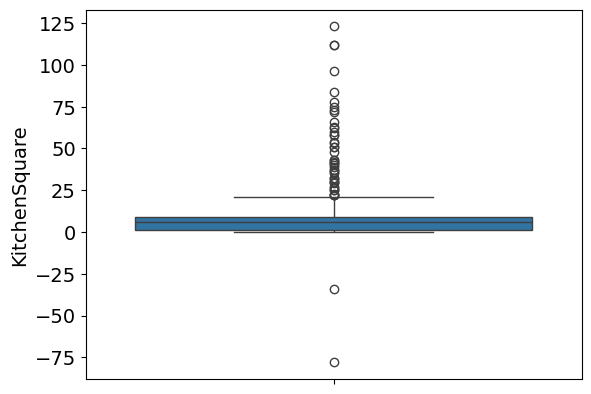

In [ ]:
sns.boxplot(df['KitchenSquare'])

Видны отрицательные выбросы и нужно определить границу слишком больших кухонь.

In [ ]:
df['KitchenSquare'].describe()

count    9999.000000
mean        5.864286
std         5.256635
min       -78.000000
25%         1.000000
50%         6.000000
75%         9.000000
max       123.000000
Name: KitchenSquare, dtype: float64

Нужно заменить отрицательные значения, значения 0 и 1.

In [ ]:
df['KitchenSquare'].quantile(0.975), df['KitchenSquare'].quantile(0.025)

(13.0, 0.0)

In [ ]:
df[df['KitchenSquare'] > 13]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
120    9703         15      4   98.686703   57.307058             15     10   
227   16395          2      3   79.722243   44.731219             72     12   
280   15679         11      2   62.927952   28.838300             17      4   
343     716        113      3  125.287183  127.477137             19     26   
359   15722         31      2   82.435495   48.655394             16     23   
...     ...        ...    ...         ...         ...            ...    ...   
9852  16641        111      4  117.201937   69.898092             14      4   
9889  12918         23      2   51.440463   53.134243             51      3   
9895   2737         27      3  123.430072  125.806981            123      5   
9910  16568         27      4  200.334539  201.627361             25      1   
9922   5954         23      2   89.149140   48.460798             14     14   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
120           17       2008   0.158249         B         B        21   
227           16       1987   0.130618         B         B        39   
280            3       2014   0.012339         B         B        35   
343           24       2017   0.050756         B         B        24   
359           40       2013   0.151346         B         A        32   
...          ...        ...        ...       ...       ...       ...   
9852           2       2017   0.093443         B         B        23   
9889          17       2017   0.005767         B         B         1   
9895          10       2015   0.017647         B         B         2   
9910           2       2013   0.041116         B         B        53   
9922          25       2012   0.075779         B         B         6   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
120       5731         0           -11            1        0       B   
227      10418         9           900            1        9       B   
280       5776         1          2078            2        4       B   
343       5469         1           145            0        1       B   
359       5889        10           830            4        1       B   
...        ...       ...           ...          ...      ...     ...   
9852      4635         5          3300            2        4       B   
9889       388         0           -11            0        0       B   
9895       469         0           -11            0        0       B   
9910     14892         4           -11            1        4       B   
9922      1437         3           -11            0        2       B   

              Price  
120   373510.057128  
227   370148.625285  
280   100378.010856  
343   522197.035995  
359   558262.139114  
...             ...  
9852  197593.112769  
9889   88150.012510  
9895  234194.837047  
9910  528560.506016  
9922  143364.948645  

[187 rows x 20 columns]

Это могут быть и большие кухни больших квартир, поэтому подберём другое условие: те значения, где площадь кухни занимает половину площади квартиры и более

In [ ]:
df[df['KitchenSquare']/df['Square'] >= 0.5]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
227   16395          2      3   79.722243   44.731219             72     12   
551    1315          6      1   48.128114   45.023531             48     21   
1077   9690         27      1   40.081042   37.834964             37     18   
1369   2371         27      2   68.841073   64.234956             66      4   
1455  12507         54      2   79.810535   79.578961             78     10   
1860   4265        161      2   53.216778   32.644859             53      7   
2916  12390         72      3   97.490674   99.323558             96     22   
2969   7441         62      3  114.734473  112.589083            112      3   
3379  16781         27      1   36.138409   36.710539             36     19   
4079   6508         23      2   67.146049   33.959154             63      5   
4110    299         27      2   66.787523   64.616662             60     14   
4142  15466         88      1   42.357487   44.779714             41     10   
4588    448         48      1   41.186904    1.626502             41      2   
4651  12552         58      3  116.405693  113.109653            112      3   
4739  12676         81      3   13.784865   15.988889              7      4   
5149  13703         42      1   38.071692   19.723548             73      9   
5162  11739         27      2   61.070298   59.845092             58      8   
5480  15781         10      1   35.813564   19.953992             35      6   
5816   2271         27      1   43.292516   42.835643             40     12   
5849  11624         46      1   42.983283   24.224435             37     15   
5888  16593         52      2   64.859242         NaN             62     15   
5904    673         27      1   54.418214   51.498581             51     10   
6036  12666         34      2   60.603363    2.400832             58     14   
6240   4966         96      3   78.445675   47.146757             75      9   
6392  14786          1      1    1.136859    4.525736              1      3   
7088   6569         27      1   38.220258   18.716856             84      4   
7480  10546         62      1   46.013187   43.417043             43      4   
8232   7162         34      2   56.738764   57.510395             54     26   
8283  15744         34      1    1.988943    2.642219              1     21   
9111   6708         48      1   42.069359   22.487739             39      1   
9889  12918         23      2   51.440463   53.134243             51      3   
9895   2737         27      3  123.430072  125.806981            123      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
227           16       1987   0.130618         B         B        39   
551            1       2013   0.243205         B         B         5   
1077          19       2019   0.211401         B         B         9   
1369           2       2014   0.017647         B         B         2   
1455          15       2014   0.006076         B         B        30   
1860          17       1994   0.000699         B         B        14   
2916          25       2019   0.210473         B         B        11   
2969           3       2015   0.072158         B         B         2   
3379          19       2017   0.072158         B         B         2   
4079          17       2019   0.034656         B         B         0   
4110          20       2015   0.017647         B         B         2   
4142          19       2016   0.127376         B         B        43   
4588           1       1977   0.041125         B         B        46   
4651           3       2016   0.437885         B         B        23   
4739           5       1960   0.319809         B         B        25   
5149          10       2006   0.158249         B         B        21   
5162          17       2016   0.072158         B         B         2   
5480          14       1971   0.282798         B         B        33   
5816          11       2015   0.2

Эти значения площади кухни слишком большие, их нужно заменить

In [ ]:
df[df['KitchenSquare'] == 2]

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
3332   3825         48      2  47.505382   30.667973              2     10   
4721  11292         29      1  24.711701   16.625634              2      3   
7897  10635         21      1  18.983962   11.419796              2      1   
9642  16202        105      1  22.072457   16.540036              2      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
3332          12       1981   0.041125         B         B        46   
4721           9       1974   0.040243         B         B        25   
7897           5       1967   0.194489         B         B        47   
9642           9       1963   0.069660         B         B        31   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
3332      9515         5           -11            1       10       B   
4721      3478        11          2729            3        1       B   
7897      8004         3           125            3        5       B   
9642      6119         4           -11            1        2       B   

              Price  
3332  211149.766549  
4721  122959.452661  
7897  112411.221700  
9642  126778.794309

У всех, кроме третьего, неправильные значения

In [ ]:
df[df['KitchenSquare'] == 3]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1476   1775        101      1   23.583220   18.442768              3      3   
2314   5798         59      3  109.698926         NaN              3     16   
3084   3732        112      1   20.213128   13.800281              3      5   
3794    523        101      1   18.509177   15.170851              3      5   
4118    828         90      1   20.924926   10.651455              3      7   
4364   9905         41      1   22.691542   13.499648              3      7   
4650  10940         75      1   24.749737   16.531306              3      5   
5560  16680         23      3   67.133598         NaN              3      2   
5667   4352        104      2   28.517666   15.565872              3      7   
6155   7729         90      1   27.298757   15.250474              3      1   
6290   6696        166      3   56.565200   38.494058              3      3   
6533   5027        101      1   26.930098   19.343318              3      3   
6590  15822         90      1   27.098441   16.660669              3      3   
6896   7384         29      1   28.091273   16.066773              3     10   
6993  14642         90      1   22.682706   14.664334              3      5   
7603   4684        101      1   26.024441   16.230387              3      4   
7694  10476         90      1   21.121279   15.202620              3      4   
8598   1098        101      1   23.015919   15.739110              3      3   
8843  14714         44      1   25.903220   18.273364              3      2   
9033   2915         29      1   23.891837   13.949307              3      5   
9227  15676        182      3   49.934561   35.980287              3      9   
9412  13299        138      1   24.769705   12.765132              3      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1476           5       1968   0.225825         A         B        41   
2314          22       1977   0.019509         B         B        37   
3084           9       1974   0.069660         B         B        31   
3794           5       1970   0.225825         A         B        41   
4118           5       1968   0.265089         B         B        37   
4364           9       1972   0.175055         B         B        36   
4650           5       1975   0.307467         B         A        30   
5560          16       2015   0.034656         B         B         0   
5667           6       1931   0.000078         B         B        22   
6155           5       1967   0.265089         B         B        37   
6290           9       1964   0.174739         B         B        17   
6533           5       1969   0.225825         A         B        41   
6590           5       1965   0.265089         B         B        37   
6896          10       2003   0.069660         B         B        31   
6993           5       1969   0.265089         B         B        37   
7603           5       1968   0.225825         A         B        41   
7694           5       1964   0.265089         B         B        37   
8598           5       1967   0.225825         A         B        41   
8843           5       1969   0.122190         B         B        25   
9033           9       1974   0.069660         B         B        31   
9227           8       1938   0.246624         B         B        14   
9412          20       1973   0.195781         B         B        23   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
1476      6558         7          1548            3        2       B   
2314      7687        11           176            5        5       B   
3084      6119         4           -11            1        2       B   
3794      6558         7          1548            3        2       B   
4118      5288         0          1937            3        2       B   
4364     10055         3           -11            1        0       B   
4650      5048         9      

У однокомнатных может быть площадь кухни == 3, но у трёхкомнатных не может.

In [ ]:
(df['KitchenSquare']/df['Square']).median()

0.12068442983806515

Итак, какие значения в KitchenSquare заменяем:
* 0 и 1 - ошибки
* 2 и 3 - смотрим на комнатность
* там, где площадь кухни > 50% от общей площади

Чем заменяем:
* высчитываем по формуле: Square * 0.15, где 15% - обычно доля кухни в квартирах.

**Р5** Заменим эти значения

In [ ]:
def update_kitchen_square(df):
  """
  Обновляет значения в столбце 'KitchenSquare' DataFrame на основе значений 'Square'.

  Args:
    df: DataFrame с данными о недвижимости, включая столбцы 'Square' и 'KitchenSquare'

  Returns:
    Обновленный DataFrame.
  """
  kitchen_proportion = 0.15

  # Заменяем значения KitchenSquare в соответствии с условиями
  df.loc[df['KitchenSquare'] <= 1, 'KitchenSquare'] = df['Square'] * kitchen_proportion
  df.loc[(df['KitchenSquare'] <= 3) & (df['Rooms'] > 1), 'KitchenSquare'] = df['Square'] * kitchen_proportion
  df.loc[(df['KitchenSquare']/df['Square'] >= 0.5), 'KitchenSquare'] = df['Square'] * kitchen_proportion

  return df

In [ ]:
df = update_kitchen_square(df.copy())

### HouseFloor

In [ ]:
df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117], dtype=int8)

0 этажей в доме быть не может, самая высокая жилая многоэтажка в России - 95 этажей.

In [ ]:
(df['Floor'] > df['HouseFloor']).sum()

1824

In [ ]:
floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
floor_outliers

Index([   7,   14,   16,   21,   23,   26,   35,   39,   44,   51,
       ...
       9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
      dtype='int64', length=1824)

**!** Я предполагаю, что столбец Floor правильный (там не было значений 0 и слишком больших значений, в отличие от столбца HouseFloor), поэтому буду отталкиваться от того, что неправильне значения именно в столбце HouseFloor.
Решила подтянуть неправильные значения в столбце HouseFloor до правильных в столбце Floor.

**Р6** Заменим те значения, где HouseFloor < Floor (туда же входят и 0) либо HouseFloor > 95

In [ ]:
def update_house_floor(df):
  """
  Обновляет значения в столбце 'HouseFloor' DataFrame на основе значений 'Floor'.

  Args:
    df: DataFrame с данными о недвижимости, включая столбцы 'Floor' и 'HouseFloor'

  Returns:
    Обновленный DataFrame.
  """

  # Заменяем значения HouseFloor в соответствии с условиями
  df['HouseFloorOutliers'] = 0
  df.loc[df['HouseFloor'] == 0, 'HouseFloorOutliers'] = 1
  df.loc[(df['Floor'] > df['HouseFloor']), 'HouseFloorOutliers'] = 1
  df.loc[df['HouseFloor'] > 95, 'HouseFloorOutliers'] = 1

  df.loc[df['HouseFloor'] < df['Floor'], 'HouseFloor'] = df['Floor']
  df.loc[df['HouseFloor'] > 95, 'HouseFloor'] = df['Floor']

  return df

In [ ]:
df = update_house_floor(df.copy())

In [ ]:
(df['HouseFloor'] < df['Floor']).sum()

0

### HouseYear
**Р7** Заменим те значения, где HouseYear = -2005 и = 4968

In [ ]:
def update_house_year(df):
  """
  Обновляет значения в столбце 'HouseYear'.

  Args:
    df: DataFrame с данными о недвижимости, включая столбцы 'HouseYear'.

  Returns:
    Обновленный DataFrame.
  """

  # Заменяем значения HouseFloor в соответствии с условиями
  df.loc[df['HouseYear'] < 0, 'HouseYear'] = abs(df['HouseYear'])
  df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df['HouseYear'].median()

  return df

In [ ]:
df = update_house_year(df.copy())

## 2.5. Отбор и построение новых признаков

### Исключаем признак "Id"

In [ ]:
df.drop(columns="Id", inplace=True)

In [ ]:
df.sample(5)

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
7511         27      1  42.003396   40.340576       6.300509     15   
9931         27      2  64.261856   41.770206       9.639278     10   
3021         14      1  36.796570   23.443824       9.000000     12   
2505         34      2  53.559028   33.148711       9.000000      3   
2992          6      2  65.409965   42.516478       9.811495     18   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
7511          17       2016   0.011654         B         B         4   
9931          10       1977   0.072158         B         B         2   
3021          12       1974   0.042032         B         B        37   
2505          17       1999   0.069753         B         B        53   
2992          18       1977   0.243205         B         B         5   

      Social_2  Social_3  Healthcare_2  Shops_1 Shops_2          Price  \
7511       915         0             0        0       B  111073.150003   
9931       629         1             0        0       A  223719.779293   
3021      6856        84             2        5       B  179619.355451   
2505     13670         4             1       11       B  245924.361950   
2992      1564         0             0        0       B  191205.272608   

      LifeSquare_NaN  HouseFloorOutliers  
7511               0                   0  
9931               1                   1  
3021               0                   0  
2505               0                   0  
2992               1                   1

### Количественные переменные

Добавим новый количественный признак - медиана цены недвижимости в том же районе - DistrictMedianPrice. Так мы сможем удалить признак DistrictId, так как он категориальный, и пришлось бы создавать 205 dummy-переменных для каждого района. А так мы сразу создадим столбец, который будет показывать влияние района на стоимость квартиры.

In [ ]:
distr_median_prices = df.groupby('DistrictId')['Price'].median()
distr_median_prices

DistrictId
0      165963.054142
1      183663.443595
10     217749.656911
100    234032.836228
101    184276.502773
           ...      
95     293249.106761
96     200440.676982
97     193772.806849
98     191914.221629
99     178829.166450
Name: Price, Length: 205, dtype: float64

In [ ]:
df['DistrictMedianPrice'] = df['DistrictId'].map(distr_median_prices)

In [ ]:
df[df['DistrictId'] == '33'].head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
454          33      2  61.472350   39.957027       9.220852     14   
549          33      3  79.566329   50.454887       8.000000      6   
689          33      1  34.492690   33.539705       5.173904      3   
1008         33      1  33.071568   21.496519       4.960735      4   
1363         33      1  31.279925   20.331952       4.691989      4   

      HouseFloor  HouseYear  Ecology_1 Ecology_2  ... Social_1  Social_2  \
454           17       1977   0.236108         B  ...       16      3893   
549            6       1959   0.051942         B  ...       17      4017   
689           15       2016   0.236108         B  ...       16      3893   
1008          10       1977   0.236108         B  ...       16      3893   
1363           8       1977   0.236108         B  ...       16      3893   

      Social_3  Healthcare_2  Shops_1  Shops_2          Price  LifeSquare_NaN  \
454         27             3       10        B  293158.975563               1   
549          7             2        0        B  396141.903506               0   
689         27             3       10        B  151028.428278               0   
1008        27             3       10        B  157045.918622               1   
1363        27             3       10        B  152656.513571               1   

      HouseFloorOutliers  DistrictMedianPrice  
454                    0         211043.11146  
549                    1         211043.11146  
689                    0         211043.11146  
1008                   0         211043.11146  
1363                   0         211043.11146  

[5 rows x 21 columns]

**Р8** Теперь можно удалить признак DistrictId, так как мы создали признак DistrictMedianPrice, отображающий влияние района на стоимость квартиры.

In [ ]:
df = df.drop('DistrictId', axis=1)

In [ ]:
df.sample(5)

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
5874      2  91.750975   42.187873      17.000000      5           8   
2649      2  53.422676   34.840353       8.000000     14          14   
6941      1  40.250474   41.416099       5.031309      1           1   
5482      1  32.866805   23.006763       4.108351      3          12   
5297      1  41.303594   41.274596       5.162949      4           4   

      HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  Social_3  \
5874       2008   0.000000         B         B         6      2733         0   
2649       1980   0.133215         B         B        49     11395         3   
6941       1977   0.011654         B         B         4       915         0   
5482       2015   0.034656         B         B         0       168         0   
5297       1977   0.371149         B         B        34      7065         1   

      Healthcare_2  Shops_1 Shops_2          Price  LifeSquare_NaN  \
5874             0        4       B  477008.222837               0   
2649             3        4       A  231285.961047               0   
6941             0        0       B   89068.104959               0   
5482             0        0       B   65167.822236               1   
5297             2        5       B  138811.337238               0   

      DistrictMedianPrice  
5874        326799.215564  
2649        200291.736422  
6941        146209.519393  
5482        113789.561738  
5297        164924.314559

### Категориальные переменные

In [ ]:
cat_feats = df.select_dtypes(include=['object'])

In [ ]:
cat_feats.sample(5)

Ecology_2 Ecology_3 Shops_2
1508         B         B       B
399          B         A       B
2235         B         B       B
2190         B         B       B
8032         B         B       B

Можно заменить на значения 1 и 0

In [ ]:
df['Ecology_2'] = (df['Ecology_2'] == 'A').astype('int8')
df['Ecology_2'].value_counts()

Ecology_2
0    9902
1      97
Name: count, dtype: int64

In [ ]:
df['Ecology_3'] = (df['Ecology_3'] == 'A').astype('int8')
df['Ecology_3'].value_counts()

Ecology_3
0    9724
1     275
Name: count, dtype: int64

In [ ]:
df['Shops_2'] = (df['Shops_2'] == 'A').astype('int8')
df['Shops_2'].value_counts()

Shops_2
0    9174
1     825
Name: count, dtype: int64

In [ ]:
df.sample(5)

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
4441      2  41.626740   31.335464            5.0      2           8   
3898      1  37.933511   21.377547            8.0     14          16   
3813      3  74.851452   47.853147            9.0      8          17   
2602      3  57.619269   40.282178            6.0      5           9   
2522      1  34.175105   18.610021            6.0      6           9   

      HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
4441       1964   0.174739          0          0        17      3379   
3898       1980   0.041125          0          0        46      9515   
3813       1997   0.000000          0          0        39      8647   
2602       1955   0.033494          0          0        66     10573   
2522       1970   0.000000          0          0        47     11319   

      Social_3  Healthcare_2  Shops_1  Shops_2          Price  LifeSquare_NaN  \
4441         9             0        3        0  247070.115670               0   
3898         5             1       10        0  199712.703298               0   
3813         0             0        5        0  365098.393421               0   
2602         1             3        8        0  239739.535546               0   
2522         0             3        5        0  168432.152954               0   

      HouseFloorOutliers  DistrictMedianPrice  
4441                   0        253259.449036  
3898                   0        240288.274803  
3813                   0        195374.148392  
2602                   0        178829.166450  
2522                   0        207183.307517

### Вещественные переменные

#### FloorCat
Попробовала разделить этажи на категории, но простой Floor показывает зависимость лучше.

#### HouseFloorCat
Разбивка на категории в зависимости от этажности дома. Признак HouseFloorCat показывает большее влияние на переменную, чем HouseFloor, но насчёт dummy-признаков не уверена, поэтому оставим только категориальный признак HouseFloorCat.

In [ ]:
df['HouseFloorCat'] = np.where((df['HouseFloor'] <= 5), 1,
                         np.where((df['HouseFloor'] <= 20), 2,
                                  3))
# 1 - низкоэтажный дом, 2 - среднеэтажный дом, 3 - высокоэтажный дом

In [ ]:
df.sample(5)

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
9678      2  54.077099   34.599683       8.000000     15          15   
2542      3  87.849086   61.494360      10.981136      5          25   
9726      1  43.100791   30.170554       5.387599     12          17   
3956      3  80.739346   45.035978      12.000000      6          14   
6601      2  43.929983   27.550528       5.000000      4           5   

      HouseYear  Ecology_1  Ecology_2  Ecology_3  ...  Shops_1  Shops_2  \
9678       1989   0.025609          0          0  ...        1        0   
2542       2016   0.069753          0          0  ...       11        0   
9726       1977   0.007122          0          0  ...        1        0   
3956       2010   0.175055          0          0  ...        0        0   
6601       1963   0.049637          0          0  ...        3        0   

              Price  LifeSquare_NaN  DistrictMedianPrice  MiddleHouse  \
9678  211449.426666               0        183663.443595            1   
2542  320797.702303               1        278693.765154            0   
9726  128124.573337               1        183663.443595            0   
3956  407973.507015               0        210694.850106            1   
6601  198316.459521               0        245978.794474            0   

      NewHouse  OldHouse  VeryOldHouse  HouseFloorCat  
9678         0         0             0              2  
2542         1         0             0              3  
9726         0         1             0              2  
3956         0         0             0              2  
6601         0         1             0              1  

[5 rows x 24 columns]

#### HouseAge
Разбивка на категории в зависимости от возраста дома. Дало хороший результат. Оказалось, что HouseYear - не очень информативный признак, а  категории по возрасту дома оказывают влияние на целевую переменную.

In [ ]:
df['HouseAgeCat'] = np.where((2021 - df['HouseYear'] < 9), 'NewHouse',
                         np.where((2021 - df['HouseYear'] <= 41), 'MiddleHouse',
                                  np.where((2021 - df['HouseYear'] < 61), 'OldHouse',
                                           'VeryOldHouse')))

In [ ]:
house_age_dummies = pd.get_dummies(df['HouseAgeCat']).astype('int8')
house_age_dummies.head()

MiddleHouse  NewHouse  OldHouse  VeryOldHouse
0            0         0         1             0
1            0         0         1             0
2            0         0         1             0
3            0         0         1             0
4            0         0         1             0

In [ ]:
df = pd.concat([df, house_age_dummies], axis=1)

In [ ]:
df = df.drop('HouseAgeCat', axis=1)

#### YearFloorMedPrice
Вычисляем медиану цены в зависимости от года постройки и этажа. Получился хороший признак.

In [ ]:
df['FloorCat'] = np.where((df['Floor'] <= 4), 1,
                          np.where((df['Floor'] <= 8), 2,
                                   np.where((df['Floor'] <= 23), 3,
                                                   np.where((df['Floor'] <= 30), 4,
                                                            5))))

In [ ]:
df['HouseYearCat'] = np.where((df['HouseYear'] < 1928), 1,
                              np.where((df['HouseYear'] <= 1941), 2,
                                       np.where((df['HouseYear'] <= 1949), 3,
                                                np.where((df['HouseYear'] <= 1961), 4,
                                                         np.where((df['HouseYear'] <= 1978), 5,
                                                                  np.where((df['HouseYear'] <= 1987), 6,
                                                                           np.where((df['HouseYear'] <= 1998), 7,
                                                                                    np.where((df['HouseYear'] <= 2011), 8,
                                                                                            9))))))))

In [ ]:
df['YearFloorMedPrice'] = df.groupby(['HouseYearCat', 'FloorCat'])['Price'].transform('median')

In [ ]:
df.drop(['FloorCat', 'HouseYearCat'], axis=1, inplace=True)    # Не показывают хорошую зависимость.

#### Social_2
Если сделать из него категориальный признак (поделить Social_2 на плохой и хороший), то этот признак будет больше влиять на целевую переменную.(0 - плохие социальные показатели, 1 - хорошие).

In [ ]:
df['Social_2'].describe()

count     9999.000000
mean      5352.645765
std       4006.702533
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7227.000000
max      19083.000000
Name: Social_2, dtype: float64

In [ ]:
df['Social_2Cat'] = np.where((df['Social_2'] <= 2700), 0,
                             1)

In [ ]:
df.sample(5)

Rooms      Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
5074      2   54.099297   36.738412       9.000000      8          16   
4810      2   56.544829   34.985946       9.000000     13          16   
1357      3  104.898559   55.606246      13.000000      4          27   
2811      1   38.697609   22.869349      12.000000     22          22   
479       3   81.126413   56.788489      10.140802      5           5   

      HouseYear  Ecology_1  Ecology_2  Ecology_3  ...  HouseFloorCat  \
5074       1982   0.037178          0          0  ...              2   
4810       1978   0.000170          0          0  ...              2   
1357       2014   0.111627          0          0  ...              3   
2811       1981   0.136244          0          0  ...              3   
479        1977   0.161532          0          0  ...              1   

      Social_2Cat  Social_3Cat  BadSocial3  GoodSocial3  MidSocial3  \
5074            2            0           1            0           0   
4810            2            0           1            0           0   
1357            2            2           0            1           0   
2811            1            0           1            0           0   
479             2            0           1            0           0   

      Shops_1Cat  BadShops  GoodShops  MidShops  
5074           2         0          1         0  
4810           0         1          0         0  
1357           1         0          0         1  
2811           0         1          0         0  
479            1         0          0         1  

[5 rows x 33 columns]

#### Social_3
Из него тоже можно сделать полезные категориальные признаки (0 - хорошие социальные показатели, 1 - средние, 2 - высокие)

In [ ]:
df['Social_3'].describe()

count    9999.000000
mean        8.040004
std        23.832931
min         0.000000
25%         0.000000
50%         2.000000
75%         5.000000
max       141.000000
Name: Social_3, dtype: float64

In [ ]:
df['Social_3Cat'] = np.where((df['Social_3'] <= 1), 0,
                             np.where((df['Shops_1'] < 5), 1,
                                        2))

#### Shops_1
Поделив на категории, получим хорошую зависимость. 0 - плохая торговая инфраструктура, 1 - средняя, 2 - хорошая

In [ ]:
df['Shops_1'].describe()

count    9999.000000
mean        4.231723
std         4.806395
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        23.000000
Name: Shops_1, dtype: float64

In [ ]:
df['Shops_1Cat'] = np.where((df['Shops_1'] <= 0), 0,
                             np.where((df['Shops_1'] < 3), 1,
                                        2))

## Итоговая матрица корреляций (с новыми признаками)
Видно влияние новых признаков на целевую переменную

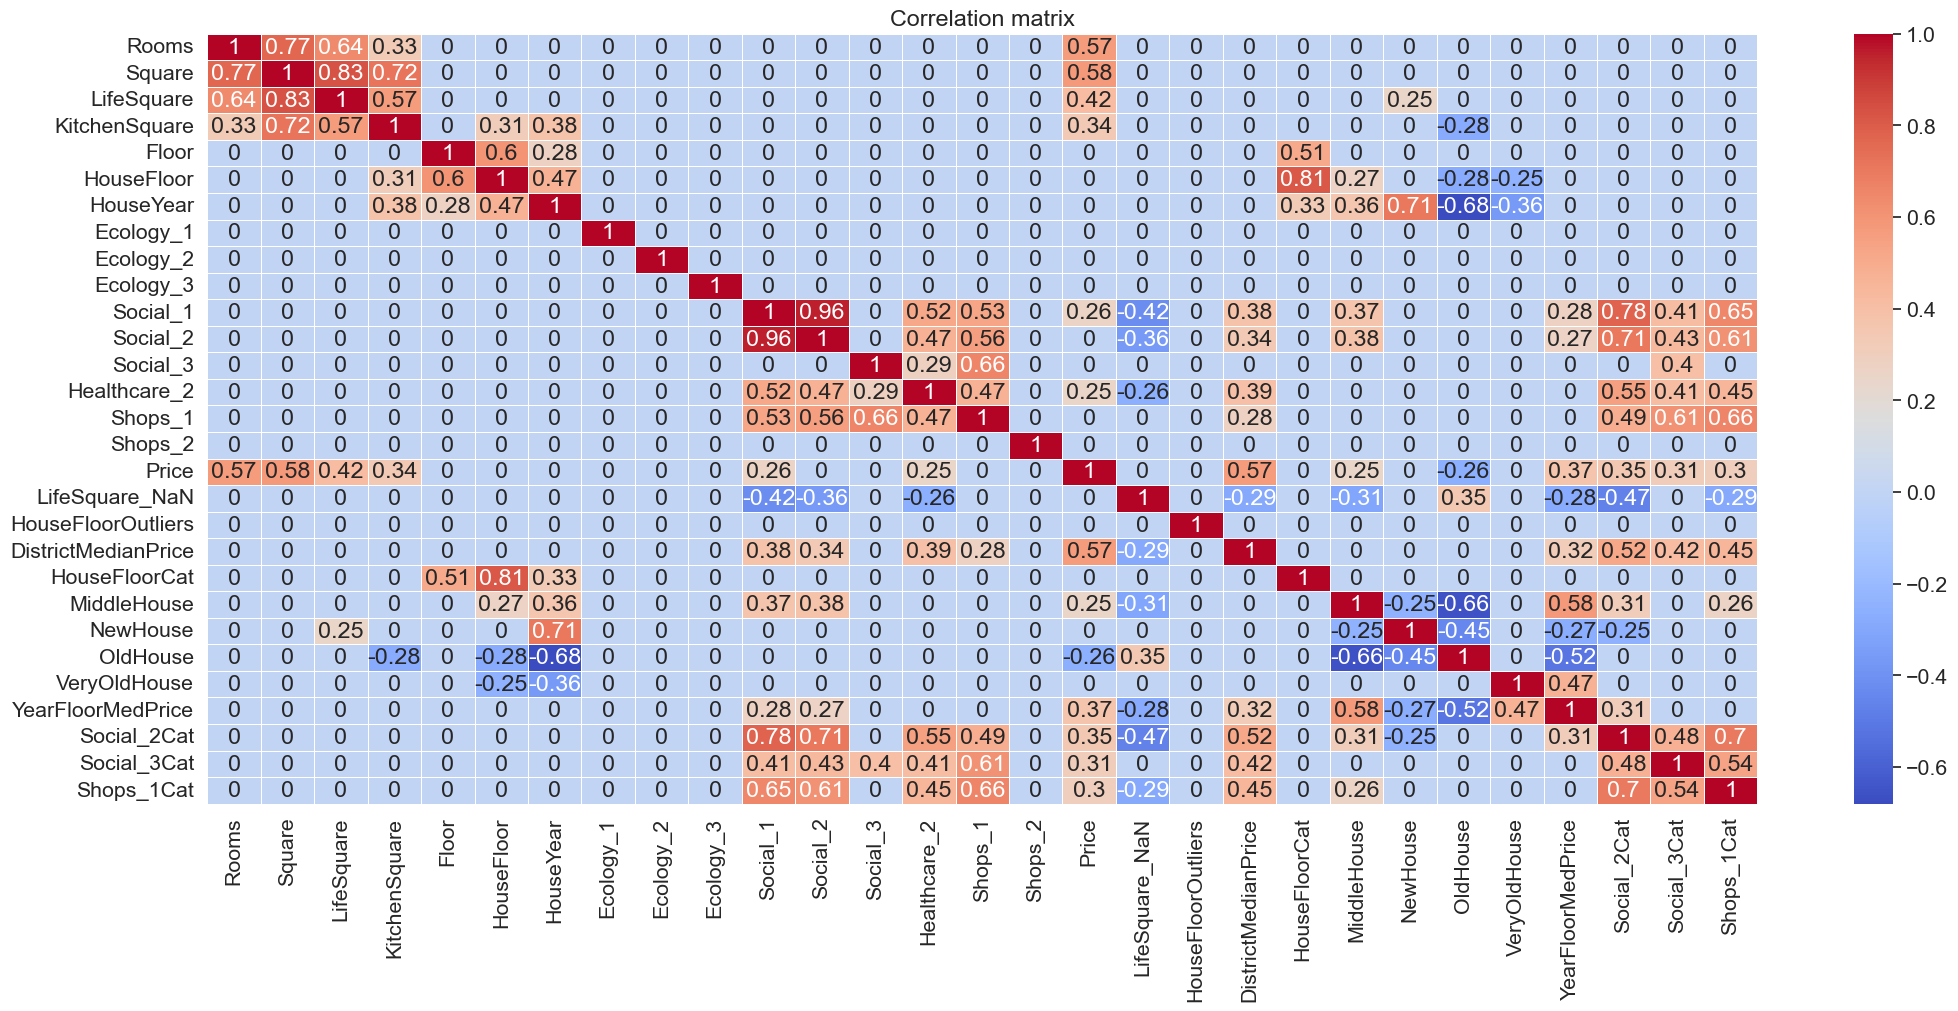

In [ ]:
plt.figure(figsize = (25,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.25] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')


plt.title('Correlation matrix')
plt.show()

## 2.6. Сохранение результатов

In [ ]:
df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=',')

# 2.7. Пайплайн предобработки
Здесь начинается запуск проекта

In [ ]:
# Все объяснения - в пунктах 1.1 - 2.6

class DataPreprocessingPipeline:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.living_area_proportion = 0.65
        self.kitchen_proportion = 0.15


    def fit(self, df):
        """Сохранение статистик"""
        # Расчет медиан
        self.room_1_median = df[df['Rooms'] == 1]['Square'].median()
        self.room_2_median = df[df['Rooms'] == 2]['Square'].median()
        self.room_3_median = df[df['Rooms'] == 3]['Square'].median()
        self.room_4_median = df[df['Rooms'] == 4]['Square'].median()
        self.room_5_median = df[df['Rooms'] == 5]['Square'].median()
        df['DistrictId'] = df['DistrictId'].astype(str)
        self.distr_median_prices = df.groupby('DistrictId')['Price'].median()
        df['FloorCat'] = np.where((df['Floor'] <= 4), 1,
                          np.where((df['Floor'] <= 8), 2,
                                   np.where((df['Floor'] <= 23), 3,
                                                   np.where((df['Floor'] <= 30), 4,
                                                            5))))
        df['HouseYearCat'] = np.where((df['HouseYear'] < 1928), 1,
                              np.where((df['HouseYear'] <= 1941), 2,
                                       np.where((df['HouseYear'] <= 1949), 3,
                                                np.where((df['HouseYear'] <= 1961), 4,
                                                         np.where((df['HouseYear'] <= 1978), 5,
                                                                  np.where((df['HouseYear'] <= 1987), 6,
                                                                           np.where((df['HouseYear'] <= 1998), 7,
                                                                                    np.where((df['HouseYear'] <= 2011), 8,
                                                                                            9))))))))
        self.year_floor_median_prices = df.groupby(['HouseYearCat', 'FloorCat'])['Price'].median()
        df.drop(['FloorCat', 'HouseYearCat'], axis=1, inplace=True)


    def transform(self, df):
        """Трансформация данных"""

        # 1. Пропуски
        df = df.drop('Healthcare_1', axis=1)
        df['LifeSquare_NaN'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_NaN'] = 1
        df['LifeSquare'] = df['LifeSquare'].fillna(df['Square'] * self.living_area_proportion)


        # 2. Выбросы (outliers)
        # Заменяем значения Rooms в соответствии с условиями
        df = df.drop(df[(df['Rooms'] == 0) & (df['Square'] < 11)].index)
        df.loc[(df['Rooms'] == 0) & (df['Square'] >= 11) & (df['Square'] <= 48.125), 'Rooms'] = 1
        df.loc[(df['Rooms'] == 0) & (df['Square'] > 48.125) & (df['Square'] <= 66.625), 'Rooms'] = 2
        df.loc[(df['Rooms'] == 0) & (df['Square'] > 66.625) & (df['Square'] <= 88.04), 'Rooms'] = 3
        df.loc[(df['Rooms'] == 0) & (df['Square'] > 88.04) & (df['Square'] <= 107.375), 'Rooms'] = 4
        df.loc[(df['Rooms'] == 0) & (df['Square'] > 107.375), 'Rooms'] = 5
        df.loc[(df['Rooms'] > 5) & (df['Square'] < 125) & (df['Square'] >= 11) & (df['Square'] <= 48.125), 'Rooms'] = 1
        df.loc[(df['Rooms'] > 5) & (df['Square'] < 125) & (df['Square'] > 48.125) & (df['Square'] <= 66.625), 'Rooms'] = 2
        df.loc[(df['Rooms'] > 5) & (df['Square'] < 125) & (df['Square'] > 66.625) & (df['Square'] <= 88.04), 'Rooms'] = 3
        df.loc[(df['Rooms'] > 5) & (df['Square'] < 125) & (df['Square'] > 88.04) & (df['Square'] <= 107.375), 'Rooms'] = 4
        df.loc[(df['Rooms'] > 5) & (df['Square'] < 125) & (df['Square'] > 107.375), 'Rooms'] = 5

        # Заменяем значения Square в соответствии с условиями
        df.loc[(df['Square'] < 11) & (df['LifeSquare'] >= 11), 'Square'] = df['LifeSquare'] / self.living_area_proportion
        df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 1), 'Square'] = self.room_1_median
        df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 2), 'Square'] = self.room_2_median
        df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 3), 'Square'] = self.room_3_median
        df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 4), 'Square'] = self.room_4_median
        df.loc[(df['Square'] < 11) & (df['LifeSquare'] < 11) & (df['Rooms'] == 5), 'Square'] = self.room_5_median
        df.loc[(df['Square'] > 300), 'LifeSquare'] = df['LifeSquare']/10
        df.loc[(df['Square'] > 300), 'Square'] = df['Square']/10

        # Заменяем значения LifeSquare в соответствии с условиями
        df.loc[(df['LifeSquare'] < 7), 'LifeSquare'] = df['Square'] * self.living_area_proportion
        df.loc[(df['LifeSquare'] / df['Square'] <= 0.25), 'LifeSquare'] = df['Square'] * self.living_area_proportion
        df.loc[(df['LifeSquare'] > 1000), 'LifeSquare'] = df['Square'] * self.living_area_proportion
        df.loc[(df['LifeSquare'] > 150) & (df['Square'] < 100), 'LifeSquare'] = df['Square'] * self.living_area_proportion

        # Заменяем значения KitchenSquare в соответствии с условиями
        df.loc[df['KitchenSquare'] <= 1, 'KitchenSquare'] = df['Square'] * self.kitchen_proportion
        df.loc[(df['KitchenSquare'] <= 3) & (df['Rooms'] > 1), 'KitchenSquare'] = df['Square'] * self.kitchen_proportion
        df.loc[(df['KitchenSquare']/df['Square'] >= 0.5), 'KitchenSquare'] = df['Square'] * self.kitchen_proportion

        # Заменяем значения HouseFloor в соответствии с условиями
        df['HouseFloorOutliers'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloorOutliers'] = 1
        df.loc[(df['Floor'] > df['HouseFloor']), 'HouseFloorOutliers'] = 1
        df.loc[df['HouseFloor'] > 95, 'HouseFloorOutliers'] = 1
        df.loc[df['HouseFloor'] < df['Floor'], 'HouseFloor'] = df['Floor']
        df.loc[df['HouseFloor'] > 95, 'HouseFloor'] = df['Floor']

        # Заменяем значения HouseYear в соответствии с условиями
        df.loc[df['HouseYear'] < 0, 'HouseYear'] = abs(df['HouseYear'])
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df['HouseYear'].median()


        # 3. Новые фичи (features)
        df.drop(columns="Id", inplace=True)

        # Медиана цены недвижимости в районе
        df['DistrictId'] = df['DistrictId'].astype(str)
        df['DistrictMedianPrice'] = df['DistrictId'].map(self.distr_median_prices)
        df = df.drop('DistrictId', axis=1)
        df['DistrictMedianPrice'] = df['DistrictMedianPrice'].fillna(df['DistrictMedianPrice'].median())


        # 4. Обработка категорий
        df['Ecology_2'] = (df['Ecology_2'] == 'A').astype('int8')
        df['Ecology_3'] = (df['Ecology_3'] == 'A').astype('int8')
        df['Shops_2'] = (df['Shops_2'] == 'A').astype('int8')

        df['HouseFloorCat'] = np.where((df['HouseFloor'] <= 5), 1,
                                 np.where((df['HouseFloor'] <= 20), 2,
                                      3))

        df['HouseAgeCat'] = np.where((2021 - df['HouseYear'] < 9), 'NewHouse',
                                 np.where((2021 - df['HouseYear'] <= 41), 'MiddleHouse',
                                      np.where((2021 - df['HouseYear'] < 61), 'OldHouse',
                                           'VeryOldHouse')))
        house_age_dummies = pd.get_dummies(df['HouseAgeCat']).astype('int8')
        df = pd.concat([df, house_age_dummies], axis=1)
        df = df.drop('HouseAgeCat', axis=1)

        df['FloorCat'] = np.where((df['Floor'] <= 4), 1,
                          np.where((df['Floor'] <= 8), 2,
                                   np.where((df['Floor'] <= 23), 3,
                                                   np.where((df['Floor'] <= 30), 4,
                                                            5))))
        df['HouseYearCat'] = np.where((df['HouseYear'] < 1928), 1,
                              np.where((df['HouseYear'] <= 1941), 2,
                                       np.where((df['HouseYear'] <= 1949), 3,
                                                np.where((df['HouseYear'] <= 1961), 4,
                                                         np.where((df['HouseYear'] <= 1978), 5,
                                                                  np.where((df['HouseYear'] <= 1987), 6,
                                                                           np.where((df['HouseYear'] <= 1998), 7,
                                                                                    np.where((df['HouseYear'] <= 2011), 8,
                                                                                            9))))))))
        df = df.merge(self.year_floor_median_prices, on=['HouseYearCat', 'FloorCat'], how='left')
        df.rename(columns={'Price': 'YearFloorMedPrice'}, inplace=True)
        df.rename(columns={'Price_x': 'Price'}, inplace=True)
        df.rename(columns={'Price_y': 'YearFloorMedPrice'}, inplace=True)
        df.drop(['FloorCat', 'HouseYearCat'], axis=1, inplace=True)
        df['YearFloorMedPrice'] = df['YearFloorMedPrice'].fillna(df['YearFloorMedPrice'].median())

        df['Social_2Cat'] = np.where((df['Social_2'] <= 2700), 0,
                                 1)

        df['Social_3Cat'] = np.where((df['Social_3'] <= 1), 0,
                                 np.where((df['Shops_1'] < 5), 1,
                                        2))

        df['Shops_1Cat'] = np.where((df['Shops_1'] <= 0), 0,
                                 np.where((df['Shops_1'] < 3), 1,
                                        2))


        # 5. Приведение типов
        df['Rooms'] = df['Rooms'].astype('int8')
        df['KitchenSquare'] = df['KitchenSquare'].astype('float32')
        df['Floor'] = df['Floor'].astype('int8')
        df['HouseFloor'] = df['HouseFloor'].astype('int8')
        df['HouseYear'] = df['HouseYear'].astype('int16')
        df['Ecology_1'] = df['Ecology_1'].astype('float32')
        df['Social_1'] = df['Social_1'].astype('int8')
        df['Social_2'] = df['Social_2'].astype('int16')
        df['Social_3'] = df['Social_3'].astype('int16')
        df = df.rename(columns={'Helthcare_2': 'Healthcare_2'})
        df['Healthcare_2'] = df['Healthcare_2'].astype('int8')
        df['Shops_1'] = df['Shops_1'].astype('int8')
        df['LifeSquare_NaN'] = df['LifeSquare_NaN'].astype('int8')
        df['HouseFloorOutliers'] = df['HouseFloorOutliers'].astype('int8')
        df['HouseFloorCat'] = df['HouseFloorCat'].astype('int8')
        df['Social_2Cat'] = df['Social_2Cat'].astype('int8')
        df['Social_3Cat'] = df['Social_3Cat'].astype('int8')
        df['Shops_1Cat'] = df['Shops_1Cat'].astype('int8')


        return df


In [ ]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare_NaN', 'HouseFloorOutliers', 'DistrictMedianPrice',
 'HouseFloorCat', 'MiddleHouse', 'NewHouse', 'OldHouse', 'VeryOldHouse', 'YearFloorMedPrice', 'Social_2Cat', 'Social_3Cat', 'Shops_1Cat']

target_name = 'Price'

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')

In [ ]:
preprocessor = DataPreprocessingPipeline()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df.to_csv('prepared_train.csv', index=False, encoding='utf-8', sep=',')

train_df.shape, test_df.shape

((9999, 29), (5000, 28))

In [ ]:
test_df.sample(5)

Rooms      Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
2213      2   92.181940   49.502352      15.000000      3          25   
3278      1   36.095944   20.391461       6.000000      7           7   
1753      3  102.223040   99.538614      15.333456      9           9   
3838      1   36.775504   23.599800       6.000000      1           5   
3627      2   46.559580   33.308254       6.000000      2           9   

      HouseYear  Ecology_1  Ecology_2  Ecology_3  ...  DistrictMedianPrice  \
2213       2013   0.075779          0          0  ...        113789.561738   
3278       1987   0.069753          0          0  ...        254553.580576   
1753       1977   0.014073          0          0  ...        113789.561738   
3838       1961   0.133215          0          0  ...        200291.736422   
3627       1969   0.050756          0          0  ...        227828.011291   

      HouseFloorCat  MiddleHouse  NewHouse  OldHouse  VeryOldHouse  \
2213              3            0         1         0             0   
3278              2            1         0         0             0   
1753              2            0         0         1             0   
3838              1            0         0         1             0   
3627              2            0         0         1             0   

      YearFloorMedPrice  Social_2Cat  Social_3Cat  Shops_1Cat  
2213      155266.293111            0            1           1  
3278      222793.482577            1            2           2  
1753      183886.977138            0            0           0  
3838      240540.785041            1            1           2  
3627      177565.257628            1            0           1  

[5 rows x 28 columns]

In [ ]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

# 3. Обучение модели

Пробовала модели: LinearRegression (67,79%), Ridge (67,85%), DecisionTreeRegressor (70,55%), RandomForestRegressor (75%), GradientBoostingRegressor (75,56%). Выбрала модель GradientBoostingRegressor. Пробовала масштабировать признаки, но без масштабирования результат оказался лучше.

## 3.3. Настройка и оценка финальной модели

In [ ]:
df2 = train_df.drop(['LifeSquare', 'Floor', 'Shops_1', 'HouseFloorCat'], axis=1)
# Методом перебора определили, без каких признаков модель работает лучше (протестировано на разных random_state)

X2 = df2.drop('Price', axis=1)
y2 = df2[target_name]

### Подбор гиперпараметров

In [ ]:
gb_model = GradientBoostingRegressor(criterion='squared_error',
                                    # max_depth=5,
                                    # max_features=9,
                                    min_samples_leaf=3,
                                    # min_samples_split=8,
                                    # n_estimators=237,
                                    random_state=23
                                    )

In [ ]:
%%time
params = {
          'max_depth': [5, 6],
          'max_features':[7, 9],
          # 'min_samples_leaf':[3, 8],
          'min_samples_split':[2, 8, 13],
          'n_estimators':[200, 225, 250]
         }

gs = GridSearchCV(gb_model, params,
                 scoring='r2',
                 cv=KFold(n_splits=5,
                         random_state=11,
                         shuffle=True),
                 n_jobs=-1)

gs.fit(X2, y2)
gs.best_params_

CPU times: total: 3.08 s
Wall time: 1min 20s


{'max_depth': 6,
 'max_features': 7,
 'min_samples_split': 13,
 'n_estimators': 200}

In [ ]:
gs.best_score_

0.7616036345618943

Итоговые гиперпараметры:
* max_depth = 6
* max_features = 7
* min_samples_leaf = 3
* min_samples_split - не ограничивать
* n_estimators = 200

### Обучение и оценка модели

In [ ]:
final_model = GradientBoostingRegressor(criterion='squared_error',
                                    max_depth=6,
                                    max_features=7,
                                    min_samples_leaf=3,
                                    n_estimators=200,
                                    random_state=33
                                    )

In [ ]:
scores = cross_val_score(final_model, X2, y2, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=6))
print(scores.mean())

0.7613952028632938


In [ ]:
# Финальное обучение модели

final_model.fit(X2, y2)

GradientBoostingRegressor(criterion='squared_error', max_depth=6,
                          max_features=7, min_samples_leaf=3, n_estimators=200,
                          random_state=33)

## 3.4. Важность признаков

In [ ]:
final_model.feature_importances_

array([1.70275773e-01, 2.65301631e-01, 5.45483572e-02, 2.42742778e-02,
       2.63221514e-02, 1.97482689e-02, 4.44793973e-05, 9.50155892e-04,
       2.74139421e-02, 3.06676850e-02, 4.40016786e-02, 7.04807583e-03,
       9.82606012e-04, 1.57160063e-03, 1.98010612e-03, 2.50060429e-01,
       5.33773426e-03, 1.34919620e-03, 3.99799517e-03, 7.55276865e-04,
       3.58310724e-02, 1.44888000e-02, 8.19969872e-03, 4.84900930e-03])

In [ ]:
feature_importances = pd.DataFrame(zip(X2.columns, final_model.feature_importances_),
                                  columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

### Топ-3 признака

In [ ]:
feature_importances.head(3)

feature_name  importance
1                Square    0.265302
15  DistrictMedianPrice    0.250060
0                 Rooms    0.170276

### Худшие 3 признака

In [ ]:
feature_importances.tail(3)

feature_name  importance
7      Ecology_3    0.000950
19  VeryOldHouse    0.000755
6      Ecology_2    0.000044

In [ ]:
feature_importances.to_csv('feature_importances.csv', index=False)

## 3.5. Сохранение модели

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [ ]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)

my_model

GradientBoostingRegressor(criterion='squared_error', max_depth=6,
                          max_features=7, min_samples_leaf=3, n_estimators=200,
                          random_state=33)

# 4. Прогнозирование на тестовом датасэте

In [ ]:
test_df.shape     # После пайплайна предобработки в пункте 2.7

(5000, 28)

In [ ]:
test_df = test_df.drop(['LifeSquare', 'Floor', 'Shops_1', 'HouseFloorCat'], axis=1)  # Потому что обучали модель без этих признаков

In [ ]:
df2.shape, X2.shape, test_df.shape

((9999, 25), (9999, 24), (5000, 24))

In [ ]:
predictions = final_model.predict(test_df)
predictions

array([157378.66729871, 221690.59000097, 226504.93761743, ...,
       335894.49870154, 193456.35186426, 178279.39120468])

In [ ]:
test_id = pd.read_csv(TEST_DATASET_PATH, sep=',')    # Чтобы вытащить Id

In [ ]:
predictions_df = pd.DataFrame(zip(test_id['Id'], predictions),
                                  columns=['Id', 'Price'])
predictions_df

Id          Price
0       725  157378.667299
1     15856  221690.590001
2      5480  226504.937617
3     15664  332208.976757
4     14275  140921.591136
...     ...            ...
4995   8180  241553.116698
4996   4695  135319.499367
4997   5783  335894.498702
4998   4780  193456.351864
4999  12504  178279.391205

[5000 rows x 2 columns]

In [ ]:
predictions_df.to_csv('YuKhismatullina_predictions.csv', index=False)

In [ ]:
df = pd.read_csv('YuKhismatullina_predictions.csv')
df

Id          Price
0       725  157378.667299
1     15856  221690.590001
2      5480  226504.937617
3     15664  332208.976757
4     14275  140921.591136
...     ...            ...
4995   8180  241553.116698
4996   4695  135319.499367
4997   5783  335894.498702
4998   4780  193456.351864
4999  12504  178279.391205

[5000 rows x 2 columns]